# **Procesamiento de Lenguaje Natural - Trabajo Práctico Nro. 2**



## **TUIA -2024**

Alumno: Marcela Flaibani

Legajo: F-3793/1

Profesores: Juan Pablo Manson, Alan Geary, Constantino Ferrucci, Dolores Sollberger


# Instalaciones

In [1]:
%%capture
!pip install chromadb spacy pandas rdflib gdown langchain-text-splitters scikit-learn transformers sentence-transformers langchain_experimental langchain-huggingface langdetect requests torch transformers deep_translator rake-nltk rank-bm25 pdfplumber wikipedia-api sacremoses
!pip install requests torch transformers pytextrank FlagEmbedding unidecode llama-index-llms-ollama wikipedia litellm[proxy] llama-index
!apt-get update
!pip install selenium webdriver-manager


# Librerías

In [2]:
# Librerías estándar de Python
import os
import re
import sqlite3
import time
import uuid
from io import BytesIO
from urllib.parse import quote

# Librerías de terceros
import chromadb
import gdown
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
import pandas as pd
import pdfplumber
import plotly.graph_objects as go
import rdflib
import requests
import spacy
import urllib.parse
import wikipediaapi
from chromadb.config import Settings
from chromadb.errors import InvalidCollectionException
from deep_translator import GoogleTranslator
from huggingface_hub import InferenceClient
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_experimental.text_splitter import SemanticChunker
from langchain_huggingface import HuggingFaceEmbeddings
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from PIL import Image
from rank_bm25 import BM25Okapi
from rdflib import Graph, URIRef, Literal, Namespace
from sentence_transformers import CrossEncoder, SentenceTransformer, util
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import MarianMTModel, MarianTokenizer
from transformers import AutoTokenizer
from urllib.parse import unquote

# Descargas necesarias para NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

from llama_index.core import Settings
from llama_index.llms.ollama import Ollama
from llama_index.core.agent import ReActAgent
from llama_index.core.tools import FunctionTool
from llama_index.core.agent.react.formatter import ReActChatFormatter
import wikipedia
from typing import List, Dict, Any

import warnings
# Ignorar FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Selenium
# Configuración más detallada de las opciones de Chrome
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--disable-gpu')

# Configurar la ruta del driver
service = Service('/usr/bin/chromedriver')

# Configuraciones

### Google Drive

In [4]:
url_documents = "https://drive.google.com/drive/folders/1e-JD7z4DdPpQP5F4-KKyxNY6mPs82yfy?usp=sharing"
url_context_data = "https://drive.google.com/drive/folders/1IS-kaXqyuyg77FF0n-bBmAObjG41cKmd?usp=sharing"
url_chroma_data = "https://drive.google.com/drive/folders/1syxhZGaejct7oC2FNNPSHvv_OuyrfUxU?usp=sharing"

gdown.download_folder(url_documents, quiet=True, output='documents')
gdown.download_folder(url_context_data, quiet=True, output='context_data')
gdown.download_folder(url_chroma_data, quiet=True, output='chroma_data')

path_documents = "documents/"
path_context_data = "context_data/"
path_chroma_data = "chroma_data/"

### Chrome - Selenium

In [5]:
def open_chrome():
    """Configura y devuelve el controlador de Selenium."""
    # Configuración más detallada de las opciones de Chrome
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-gpu')

    # Configurar la ruta del driver
    service = Service('/usr/bin/chromedriver')
    # Inicializar el webdriver
    driver = webdriver.Chrome(options=chrome_options)
    return driver

def close_chrome(driver):
    driver.quit()

url_game = "https://boardgamegeek.com/boardgame/220877/rajas-of-the-ganges"
url_game_credits = "https://boardgamegeek.com/boardgame/220877/rajas-of-the-ganges/credits"
url_game_stats = "https://boardgamegeek.com/boardgame/220877/rajas-of-the-ganges/stats"

### ChromaDB

In [6]:
# Configurar el cliente de ChromaDB
chroma_client = chromadb.PersistentClient(path=path_chroma_data)
# Nombre de la colección
collection_name = "rajasoftheganges"
try:
    # Intentar obtener la colección
    collection = chroma_client.get_collection(name=collection_name)
    print(f"Colección '{collection_name}' encontrada y abierta.")
except InvalidCollectionException:
    # Si no existe, crear la colección
    collection = chroma_client.create_collection(name=collection_name)
    print(f"Colección '{collection_name}' creada exitosamente.")

Colección 'rajasoftheganges' encontrada y abierta.


### HUGGINGFACE_TOKEN

In [7]:
# Secretos de Google Colab
from google.colab import userdata
api_key = userdata.get('HUGGINGFACE_TOKEN')

# Reemplazar con su token: api = HUGGINGFACE_TOKEN
client = InferenceClient(api_key=api_key)


### Modelos

In [8]:
# Cargar el modelo y su tokenizador
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Ajustar clean_up_tokenization_spaces si es posible (directamente en el tokenizador)
tokenizer.clean_up_tokenization_spaces = False
# Modelo para vectorizar - Usar SentenceTransformer
model = SentenceTransformer(model_name) # Modelo optimizado para embedding

# Modelo para generación de chunks
model_embedding_name = "sentence-transformers/all-MiniLM-L12-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
hf = HuggingFaceEmbeddings(
    model_name=model_embedding_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

# Modelo y tokenizador para traducción
model_name_de_en = 'Helsinki-NLP/opus-mt-de-en'  # Modelo para alemán a inglés
model_de_en = MarianMTModel.from_pretrained(model_name_de_en)
tokenizer_de_en = MarianTokenizer.from_pretrained(model_name_de_en)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

In [9]:
translator = GoogleTranslator(source='auto', target='en')


# Ejercicio 1: RAG

## Base de Datos Vectorial
* chroma.sqlite3

### Funciones

In [21]:
def extract_text_from_pdf(pdf_path: str) -> str:
    """
    Extrae el texto de un archivo PDF.
    Args:
        pdf_path (str): Ruta del archivo PDF desde el cual se extraerá el texto.
    Returns:
        str: Texto extraído del archivo PDF.
    """
    with pdfplumber.open(pdf_path) as pdf:
      text = ""
      for page in pdf.pages:
          text += page.extract_text()
    return text

def view_pdf_chunks(pdf_path: str, metadata: dict) -> List[str]:
    """
    Extrae y divide el texto de un archivo PDF en fragmentos semánticos.
    Args:
        pdf_path (str): Ruta del archivo PDF desde el que extraer el texto.
        metadata (dict): Metadatos que acompañan los documentos para su almacenamiento.
    Returns:
        List[str]: Una lista de fragmentos de texto extraídos del PDF.
    """
    text = extract_text_from_pdf(pdf_path)
    splitter = SemanticChunker(hf)
    chunks = splitter.split_text(text)
    return chunks

def process_pdf_to_vector_db(pdf_path: str, metadata: dict) -> None:
    """
    Extrae texto de un archivo PDF, lo divide en fragmentos semánticos, genera embeddings y los almacena
    en una base de datos vectorial.
    Args:
        pdf_path (str): Ruta del archivo PDF.
        metadata (dict): Metadatos que acompañan los documentos para su almacenamiento.
    Returns:
        None
    """
    text = extract_text_from_pdf(pdf_path)
    splitter = SemanticChunker(hf)
    chunks = splitter.split_text(text)

    # Generar embeddings
    embeddings = model.encode(chunks)
    collection = chroma_client.get_collection(name="rajasoftheganges")

    # Generar un identificador único basado en el nombre del archivo
    base_id = metadata["source"].replace(" ", "_").replace(".", "_").lower()

    for i, (chunk, embedding) in enumerate(zip(chunks, embeddings)):
        unique_id = f"{base_id}_chunk_{i}"  # ID único basado en el archivo y el índice
        metadata["chunk_index"] = i  # Actualizar el índice
        collection.add(
            ids=[unique_id],
            embeddings=[embedding.tolist()],  # Convertir tensor a lista
            metadatas=[metadata],
            documents=[chunk]
        )
    print(f"Datos de {pdf_path} almacenados.")

def extract_text_wikipedia(url: str, language: str = "en") -> str:
    """
    Extrae y limpia el texto de una página de Wikipedia.
    Esta función obtiene el contenido de una página de Wikipedia utilizando su API y devuelve el texto limpio.
    El texto extraído es el cuerpo principal de la página, sin la información adicional (como la tabla de contenido o los enlaces).
    Args:
        url (str): URL completa de la página de Wikipedia. El título de la página será extraído de la URL.
        language (str, opcional): Código del idioma de la página de Wikipedia (por ejemplo, 'de' para alemán, 'es' para español, 'en' para inglés).
                                   El valor predeterminado es 'en' (inglés).
    Returns:
        str: El texto limpio extraído de la página de Wikipedia. Si la página no existe o hay algún error,
             se devuelve un mensaje indicando que no se pudo encontrar la página.
    """
    # Obtener el título desde la URL
    titulo = url.split("/")[-1]
    # Crear una instancia de Wikipedia en el idioma deseado
    user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36 Edg/110.0.1587.46"
    wiki_wiki = wikipediaapi.Wikipedia(language=language, user_agent=user_agent)
    # Obtener la página
    page = wiki_wiki.page(titulo)
    if not page.exists():
        return f"La página '{titulo}' no existe en Wikipedia en idioma '{language}'."
    return page.text

def translate(model_de_en, tokenizer_de_en, text: str) -> str:
    """
    Traduce un texto del alemán al inglés utilizando un modelo de traducción preentrenado.
    Esta función toma un texto en alemán y lo traduce al inglés usando el modelo de traducción
    y el tokenizador proporcionados. Los tokens son generados a partir del texto de entrada y
    luego se decodifican para producir el texto traducido.
    Args:
        model_de_en: El modelo preentrenado para la traducción de alemán a inglés
        tokenizer_de_en: El tokenizador correspondiente al modelo de traducción, utilizado para convertir el texto en tokens.
        text (str): El texto en alemán que se desea traducir al inglés.
    Returns:
        str: El texto traducido al inglés.
    """
    # Traducción de alemán a inglés
    tokenizer = tokenizer_de_en
    model = model_de_en
    # Tokenización y traducción
    tokens = tokenizer(text, return_tensors="pt", padding=True)
    translated_tokens = model.generate(**tokens)
    translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
    return translated_text

def view_url_chunks(url: str, metadata: dict, language: str) -> list:
    """
    Extrae el texto de una página de Wikipedia y lo divide en fragmentos (chunks)..
    Args:
        url (str): La URL de la página de Wikipedia de la que se extraerá el texto.
        metadata (dict): Un diccionario con metadatos relacionados con la página.
        language (str): El idioma de la página de Wikipedia (por ejemplo, 'en' para inglés, 'es' para español).
    Returns:
        list: Una lista de fragmentos de texto extraídos y divididos de la página de Wikipedia.
    """
    wikipedia_text = extract_text_wikipedia(url, language=language)
    splitter = SemanticChunker(hf)
    chunks = splitter.split_text(wikipedia_text)
    return chunks

def process_url_to_vector_db(url: str, metadata: dict, model_de_en, tokenizer_de_en, language: str) -> None:
    """
    Procesa el texto de una URL de Wikipedia, lo traduce si es necesario,
    genera embeddings y los almacena en una base de datos vectorial.
    Args:
        url (str): URL de la página de Wikipedia a procesar.
        metadata (dict): Diccionario con metadatos asociados a la URL,
                         como el idioma de origen o la fuente.
        model_de_en: Modelo de traducción de alemán a inglés.
        tokenizer_de_en: Tokenizador asociado al modelo de traducción.
        language (str): Código de idioma del contenido de la URL (por ejemplo, 'en', 'de', 'es').
    Returns:
        None: La función no retorna valores; los datos procesados se almacenan en la base de datos vectorial.
    """
    wikipedia_text = extract_text_wikipedia(url, language=language)
    splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, separators=["\n\n", "\n", " "])
    chunks = splitter.split_text(wikipedia_text)
    if metadata.get("language") == "de":
        # Traducir chunks si están en alemán
        chunks = [translate(model_de_en, tokenizer_de_en, chunk) for chunk in chunks]

    # Generar embeddings
    embeddings = model.encode(chunks)
    collection = chroma_client.get_collection(name="rajasoftheganges")

    # Generar un identificador único basado en la URL
    base_id = metadata["source"].replace(" ", "_").replace(".", "_").lower()

    for i, (chunk, embedding) in enumerate(zip(chunks, embeddings)):
        unique_id = f"{base_id}_chunk_{i}"  # ID único basado en la URL y el índice
        metadata["chunk_index"] = i  # Actualizar el índice
        collection.add(
            ids=[unique_id],
            embeddings=[embedding.tolist()],  # Convertir tensor a lista
            metadatas=[metadata],
            documents=[chunk]
        )
    print(f"Datos de {url} almacenados.")

### Fuentes de datos

#### PDFs

In [22]:
# Lista de metadatos para los PDFs
pdf_metadata = [
    {
        "source": "Rajas_of_the_Ganges_Rules.pdf",
        "source_type": "pdf",
        "category": "rules",
        "content_type": "text",
        "language": "en",
    },
    {
        "source": "Rajas_of_the_Ganges_Quick_Rules_Guide.pdf",
        "source_type": "pdf",
        "category": "rules",
        "content_type": "text",
        "language": "en",
    },
    {
        "source": "Rajas_of_the_Ganges_Automa_r1.0.pdf",
        "source_type": "pdf",
        "category": "automa",
        "content_type": "text",
        "language": "en",
    },
    {
        "source": "Rajas_of_the_Ganges_-_Solo_version_v1.1.pdf",
        "source_type": "pdf",
        "category": "solo version",
        "content_type": "text",
        "language": "en",
    },
]

# Inspección de los chunks
# for metadata in pdf_metadata:
#     file_path = path_documents + metadata["source"]
#     chunk = view_pdf_chunks(file_path, metadata)
#     for i in chunk:
#         print(f"\nNEW CHUNK: {i}")
#     print(len(chunk))

# Procesar cada PDF en el bucle
# for metadata in pdf_metadata:
#     file_path = path_documents + metadata["source"]
#     process_pdf_to_vector_db(file_path, metadata)


#### Wikipedia

In [23]:
# Lista de metadatos para las URLs de Wikipedia
url_metadata = [
    {
        # Rajas of the Ganges
        "source": "https://de.wikipedia.org/wiki/Rajas_of_the_Ganges",
        "source_type": "url",
        "category": "rajas of the ganges",
        "content_type": "text",
        "language": "de",
    },
    {
        # Imperio mogol
        "source": "https://de.wikipedia.org/wiki/Mogulreich",
        "source_type": "url",
        "category": "history",
        "content_type": "text",
        "language": "de",
    },
    {
        # Juegos de mesa
        "source": "https://de.wikipedia.org/wiki/Brettspiel#Brettspiele_am_Computer_und_im_Internet",
        "source_type": "url",
        "category": "board games",
        "content_type": "text",
        "language": "de",
    },
    {
        # Juegos de mesa
        "source": "https://en.wikipedia.org/wiki/Board_game",
        "source_type": "url",
        "category": "board games",
        "content_type": "text",
        "language": "en",
    },
    {
        # Diseñadores
        "source": "https://de.wikipedia.org/wiki/Inka_und_Markus_Brand",
        "source_type": "url",
        "category": "designer",
        "content_type": "text",
        "language": "de",
    },
    {
        # Colocación de trabajadores
        "source": "https://de.wikipedia.org/wiki/Worker_Placement",
        "source_type": "url",
        "category": "mechanics",
        "content_type": "text",
        "language": "de",
    },
    {
        # publicista
        "source": "https://de.wikipedia.org/wiki/Huch!",
        "source_type": "url",
        "category": "publisher",
        "content_type": "text",
        "language": "de",
    },
    {
        # publicista
        "source": "https://de.wikipedia.org/wiki/999_Games",
        "source_type": "url",
        "category": "publisher",
        "content_type": "text",
        "language": "de",
    },
    {
        # Premios
        "source": "https://de.wikipedia.org/wiki/International_Gamers_Award",
        "source_type": "url",
        "category": "awards",
        "content_type": "text",
        "language": "de",
    },
    {
        # Premios
        "source": "https://de.wikipedia.org/wiki/Spiel_(Messe)",
        "source_type": "url",
        "category": "awards",
        "content_type": "text",
        "language": "de",
    },
    {
        # Premios
        "source": "https://de.wikipedia.org/wiki/Deutscher_Spielepreis",
        "source_type": "url",
        "category": "awards",
        "content_type": "text",
        "language": "de",
    },
    {
        # Subcontinente Indio
        "source": "https://en.wikipedia.org/wiki/Indian_subcontinent",
        "source_type": "url",
        "category": "geography",
        "content_type": "text",
        "language": "en",
    },
    {
        # Rajá
        "source": "https://en.wikipedia.org/wiki/Raja",
        "source_type": "url",
        "category": "history",
        "content_type": "text",
        "language": "en",
    },
    {
        # Rajá
        "source": "https://de.wikipedia.org/wiki/Raja",
        "source_type": "url",
        "category": "history",
        "content_type": "text",
        "language": "de",
    },
    {
        # Kail
        "source": "https://de.wikipedia.org/wiki/Kali_(G%C3%B6ttin)",
        "source_type": "url",
        "category": "religion",
        "content_type": "text",
        "language": "de",
    },
    {
        # Blue peacook
        "source": "https://de.wikipedia.org/wiki/Blauer_Pfau#Pfauen_in_Religion_und_Mythologie",
        "source_type": "url",
        "category": "religion",
        "content_type": "text",
        "language": "de",
    },
    {
        # peacook throne
        "source": "https://de.wikipedia.org/wiki/Pfauenthron",
        "source_type": "url",
        "category": "history",
        "content_type": "text",
        "language": "de",
    },
    {
        # Yoga
        "source": "https://en.wikipedia.org/wiki/Yoga",
        "source_type": "url",
        "category": "philosophy",
        "content_type": "text",
        "language": "en",
    },
    {
        # Raja Man Singh
        "source": "https://de.wikipedia.org/wiki/Man_Singh_I.",
        "source_type": "url",
        "category": "history",
        "content_type": "text",
        "language": "de",
    },
    {
        # Delfin del ganges
        "source": "https://de.wikipedia.org/wiki/Gangesdelfin",
        "source_type": "url",
        "category": "nature",
        "content_type": "text",
        "language": "de",
    },
]

# Inspección de los chunks
# for metadata in url_metadata:
#     chunk = view_url_chunks(metadata["source"], metadata, metadata["language"])
#     for i in chunk:
#         print(f"\nNEW CHUNK: {i}")
#     print(len(chunk))

# Procesar cada URL en el bucle
# for metadata in url_metadata:
#     process_url_to_vector_db(metadata["source"], metadata, model_de_en, tokenizer_de_en, metadata["language"])


#### Reseña

In [24]:
# https://misutmeeple.com/2018/01/resena-rajas-of-the-ganges/

### Queries

In [25]:
collection = chroma_client.get_collection(name="rajasoftheganges")

In [26]:
query = "¿what is the game objetive?"
query_embedding = model.encode([query])
# query_embedding = encode_text_e5([query], prefix="query:")

results = collection.query(
    query_embeddings=query_embedding,
    n_results=3  # Número de resultados relevantes
)

for result, metadata in zip(results['documents'], results['metadatas']):
    print("Fragmento relevante:", result)
    print("Metadatos:", metadata)


Fragmento relevante: ['The creative didactical board game The creative learning game starts the playing and learning processes already when creating the board game. The gamers follow a game idea and create themselves found rules, which they turn into a board game according to their own ideas. The self-developed game can be used as a practice game, but also at any time by new (improved) rules. In the creative board game, not only finished game templates are played according to foreign action specifications. It pursues the double purpose, first in a first learning process in the discovering game, to design and construct their own board game, then to use it playfully in a second, a practicing follow-up process and at the same time to strengthen and deepen the knowledge gained.', 'Weblinks Bayerisches Landesverzeichnis für das Immaterialielle Kulturverzeichnis der UNESCO Förderung von Brettspiele – Awarding 2021 at the Toy Museum Nuremberg on the website of the Institute of Ludology Luding

In [27]:
query = "Who is the designer of the rajas of the ganges game"
query_embedding = model.encode([query])

results = collection.query(
    query_embeddings=query_embedding,
    n_results=3  # Número de resultados relevantes
)

for result, metadata in zip(results['documents'], results['metadatas']):
    print("Fragmento relevante:", result)
    print("Metadatos:", metadata)


Fragmento relevante: ['Rajas of the Ganges is a board game by game designers Inka and Markus Brand, which was published by Huch! in 2017. It is a worker-placement game, in which additional dice for actions have to be used and a locality built on a separate player tableau. As a special feature, the two opposing score bars for money and fame, which determine the winner of the game, are considered. The game was awarded the International Gamers Award in the category "Multiplayer" in 2018 and in the same year was voted 3rd place at the German Game Prize 2018.', 'Background and Game Material Thematically, Rajas of the Ganges is located in the emerging Mughal Empire on the Indian subcontinent, where players in the role of Rajas and Ranis need to open up new lands and markets for silk, tea and spices in order to lead their own provinces to wealth and fame. By placing a limited number of workers (Worker Placement) and the use of dice on the game plan, the players build their provincial table an

In [28]:
# Obtener la colección
collection = chroma_client.get_collection(name="rajasoftheganges")

# Obtener todos los datos cargados en la colección
all_data = collection.get()

# Mostrar los datos
print(all_data)


{'ids': ['rajas_of_the_ganges_rules_pdf_chunk_0', 'rajas_of_the_ganges_rules_pdf_chunk_1', 'rajas_of_the_ganges_rules_pdf_chunk_2', 'rajas_of_the_ganges_rules_pdf_chunk_3', 'rajas_of_the_ganges_rules_pdf_chunk_4', 'rajas_of_the_ganges_rules_pdf_chunk_5', 'rajas_of_the_ganges_rules_pdf_chunk_6', 'rajas_of_the_ganges_rules_pdf_chunk_7', 'rajas_of_the_ganges_rules_pdf_chunk_8', 'rajas_of_the_ganges_rules_pdf_chunk_9', 'rajas_of_the_ganges_rules_pdf_chunk_10', 'rajas_of_the_ganges_rules_pdf_chunk_11', 'rajas_of_the_ganges_rules_pdf_chunk_12', 'rajas_of_the_ganges_rules_pdf_chunk_13', 'rajas_of_the_ganges_rules_pdf_chunk_14', 'rajas_of_the_ganges_rules_pdf_chunk_15', 'rajas_of_the_ganges_rules_pdf_chunk_16', 'rajas_of_the_ganges_rules_pdf_chunk_17', 'rajas_of_the_ganges_quick_rules_guide_pdf_chunk_0', 'rajas_of_the_ganges_quick_rules_guide_pdf_chunk_1', 'rajas_of_the_ganges_quick_rules_guide_pdf_chunk_2', 'rajas_of_the_ganges_quick_rules_guide_pdf_chunk_3', 'rajas_of_the_ganges_quick_rules_

## Base de Datos de Grafos
* game_graph.rdf

### Extracción de la página principal: url_games

In [29]:
def extract_awards(driver: webdriver.Chrome, url: str) -> list:
    """
    Extrae premios y honores de la página principal de un juego desde la URL proporcionada.
    Args:
        driver (webdriver.Chrome): Instancia del controlador de Selenium para interactuar con la página web.
        url (str): URL de la página principal del juego.
    Returns:
        list: Una lista de cadenas que representan los premios y honores extraídos.
    """
    """Extrae premios y honores de la página principal de un juego."""
    driver.get(url)
    awards = []

    try:
        # # Espera a que el encabezado de premios esté presente
        # header_selector = "//h3[contains(text(), 'Awards & Honors')]"
        # WebDriverWait(driver, 10).until(
        #     EC.presence_of_element_located((By.XPATH, header_selector))
        # )
        time.sleep(5)
        # Busca los premios dentro del contenedor
        awards_selector = "//a[@class='ng-binding'][contains(@ng-href, '/boardgamehonor/')]"
        awards_elements = driver.find_elements(By.XPATH, awards_selector)

        # Extraer el texto de los premios
        awards = [award.text.strip() for award in awards_elements if award.text.strip()]
    except Exception as e:
        print(f"Error extracting awards: {e}")

    return awards


driver = open_chrome()
awards_data = extract_awards(driver, url_game)
print("Awards:", awards_data)
driver.quit()

Awards: ['2019 MinD-Spielepreis Complex Game Nominee', '2018 Juego del Año Recommended', '2018 International Gamers Award - General Strategy: Multi-player Winner', '2018 International Gamers Award - General Strategy: Multi-player Nominee']


### Extracción de la página: url_games_credits

In [30]:
# Configuración para hacer que la detección del idioma sea consistente entre ejecuciones
DetectorFactory.seed = 0

def extract_game_credits_data(driver: webdriver.Chrome, url: str) -> dict:
    """
    Extrae datos del juego desde la página de créditos y detecta el idioma de los nombres alternativos.
    Args:
        driver (webdriver.Chrome): Instancia del controlador de Selenium para interactuar con la página web.
        url (str): URL de la página de créditos del juego.
    Returns:
        dict: Un diccionario con información del juego, incluyendo nombres alternativos, categorías y su idioma detectado.
    """
    driver.get(url)
    data = {}
    data['Name'] = "Rajas of the Ganges"
    data['Year'] = "2017"

    try:
        # Nombres alternativos con detección de idioma
        alternate_name_selector = "div[ng-repeat='name in creditsctrl.geekitem.data.item.alternatenames']"
        alternate_name_elements = driver.find_elements(By.CSS_SELECTOR, alternate_name_selector)
        data["AlternateNames"] = []

        for name in alternate_name_elements:
            alt_name = name.text.strip()
            if alt_name:
                try:
                    lang = detect(alt_name)  # Detección de idioma
                except LangDetectException:
                    lang = "unknown"
                data["AlternateNames"].append({"Name": alt_name, "Language": lang})
    except Exception as e:
        print(f"Error extracting alternate names: {e}")
        data["AlternateNames"] = []

    try:
        # Categorías
        category_selector = "a.ng-binding[href*='/boardgamecategory/']"
        category_elements = driver.find_elements(By.CSS_SELECTOR, category_selector)
        data["Categories"] = [category.text.strip() for category in category_elements if category.text.strip()]
    except Exception as e:
        print(f"Error extracting categories: {e}")
        data["Categories"] = []

    return data


driver = open_chrome()
game_data = extract_game_credits_data(driver, url_game_credits)
print(game_data)
driver.quit()


{'Name': 'Rajas of the Ganges', 'Year': '2017', 'AlternateNames': [{'Name': 'Ganges', 'Language': 'de'}, {'Name': 'I Ragià del Gange', 'Language': 'ca'}, {'Name': "Raja's van de Ganges", 'Language': 'nl'}, {'Name': 'Раджи Ганга', 'Language': 'bg'}, {'Name': 'ガンジスの藩王', 'Language': 'ja'}, {'Name': '갠지스의 라자', 'Language': 'ko'}], 'Categories': ['Dice', 'Economic', 'Renaissance', 'Territory Building']}


In [31]:
def find_urls(driver: webdriver.Chrome, url: str, data: str) -> list:
    """
    Encuentra y devuelve una lista de URLs específicas desde una página.
    Args:
        driver (webdriver.Chrome): Instancia del controlador de Selenium para interactuar con la página web.
        url (str): URL de la página donde se buscarán los enlaces.
        data (str): Sufijo de la URL para filtrar enlaces (por ejemplo, 'category', 'mechanic').
    Returns:
        list: Lista de URLs extraídas que coinciden con el patrón especificado.
    """
    driver.get(url)
    urls = []
    selector = f'a.ng-binding[ng-href*="/boardgame{data}/"]'
    links = driver.find_elements(By.CSS_SELECTOR, selector)
    urls = [link.get_attribute('href') for link in links]
    return urls

driver = open_chrome()
url_designers = find_urls(driver, url_game_credits, 'designer')
url_artists = find_urls(driver, url_game_credits, 'artist')
url_publishers = find_urls(driver, url_game_credits, 'publisher')
url_family = find_urls(driver, url_game_credits, 'family')
driver.quit()

In [32]:
url_designers, url_artists, url_publishers, url_family

(['https://boardgamegeek.com/boardgamedesigner/6940/inka-brand',
  'https://boardgamegeek.com/boardgamedesigner/6941/markus-brand'],
 ['https://boardgamegeek.com/boardgameartist/12484/dennis-lohausen'],
 ['https://boardgamegeek.com/boardgamepublisher/3490/huch',
  'https://boardgamegeek.com/boardgamepublisher/267/999-games',
  'https://boardgamegeek.com/boardgamepublisher/2366/devir',
  'https://boardgamegeek.com/boardgamepublisher/46544/dice-realm',
  'https://boardgamegeek.com/boardgamepublisher/917/dv-games',
  'https://boardgamegeek.com/boardgamepublisher/7496/egmont-polska',
  'https://boardgamegeek.com/boardgamepublisher/37681/fabrika-igr',
  'https://boardgamegeek.com/boardgamepublisher/12540/game-harbor',
  'https://boardgamegeek.com/boardgamepublisher/17130/hot-games',
  'https://boardgamegeek.com/boardgamepublisher/52507/nostalgia-iii',
  'https://boardgamegeek.com/boardgamepublisher/105/r-and-r-games'],
 ['https://boardgamegeek.com/boardgamefamily/22783/admin-better-descript

### Extracción de los links de: designers, artists, publishers y related

In [33]:
def extract_designer_artist_data(driver: webdriver.Chrome, url: str, issue: str) -> dict:
    """
    Extrae datos relacionados con diseñadores o artistas desde la página web.
    Args:
        driver (webdriver.Chrome): Instancia del controlador de Selenium para interactuar con el navegador.
        url (str): URL de la página de donde se extraerán los datos.
        issue (str): Tipo de datos a extraer ('boardgamedesigner' o 'boardgameartist').
    Returns:
        dict: Diccionario con la información extraída, incluyendo nombres, microbadges, premios y top games.
    """
    driver.get(url)
    data = {}

    try:
        # Nombre del diseñador
        selector = f'a.ng-binding[ng-href*="/{issue}/"]'
        element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, selector))
        )
        data['Name'] = element.text.strip()
    except Exception as e:
        print(f"Error extracting name: {e}")
        data['Name'] = None

    try:
        # Microbadges
        microbadges = driver.find_elements(By.XPATH, "//a[contains(@href, '/microbadge/')]/img")
        if len(microbadges) > 0:
            data['Microbadge1'] = {
                'Name': microbadges[0].get_attribute('alt'),
                'Image': microbadges[0].get_attribute('src'),
            }
        if len(microbadges) > 1:
            data['Microbadge2'] = {
                'Name': microbadges[1].get_attribute('alt'),
                'Image': microbadges[1].get_attribute('src'),
            }
    except Exception as e:
        print(f"Error extracting microbadges: {e}")

    try:
        # Premios y Honores
        awards = driver.find_elements(By.CSS_SELECTOR, "a.ng-binding[href*='/boardgamehonor/']")
        data['Awards'] = [award.text.strip() for award in awards]
    except Exception as e:
        print(f"Error extracting awards: {e}")
        data['Awards'] = []

    try:
        # Esperar a que se cargue el título de los Top Games
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "h2.panel-title.ng-binding"))
        )
        # Extraer los títulos de los Top Games
        game_elements = driver.find_elements(By.CSS_SELECTOR, "a.rec h3.rec-title")[:10]
        # Procesar los nombres para eliminar prefijos como "Exit: The Game –"
        data['TopGames'] = [
            game.text.split("–", 1)[-1].strip() if "–" in game.text else game.text.strip()
            for game in game_elements
        ]
    except Exception as e:
        print(f"Top Games not found for {issue} at {url}: {e}")
        data['TopGames'] = []

    return data

def extract_publisher_data(driver, url):
    """Extrae datos relacionados con publishers."""
    driver.get(url)
    data = {}

    try:
        # Nombre del editor
        selector = 'a.ng-binding[ng-href*="/boardgamepublisher/"]'
        element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, selector))
        )
        data['Name'] = element.text.strip()
    except Exception as e:
        print(f"Error extracting publisher name: {e}")
        data['Name'] = None

    return data

def extract_family_data(driver, url):
    """Extrae datos relacionados con familias (relaciones temáticas)."""
    driver.get(url)
    data = {}

    try:
        # Relación temática
        selector = 'a.ng-binding[ng-href*="/boardgamefamily/"]'
        # element = WebDriverWait(driver, 10).until(
        #     EC.presence_of_element_located((By.CSS_SELECTOR, selector))
        # )
        time.sleep(5)
        element = driver.find_element(By.CSS_SELECTOR, selector)
        subject = element.text.strip()
        if ":" in subject:
            parts = subject.split(":", 1)
            data['Theme'] = parts[0].strip()
            data['Name'] = parts[1].strip()
        else:
            data['Theme'] = subject.strip()
            data['Name'] = None
    except Exception as e:
        print(f"Error extracting family data: {e}")
        data['Theme'] = None
        data['Name'] = None

    return data

def get_data_by_issue(driver, issue, urls):
    """Función general para procesar diferentes tipos de datos."""
    result = []
    for url in urls:
        if issue == "boardgamedesigner":
            result.append(extract_designer_artist_data(driver, url, issue))
        if issue == "boardgameartist":
            result.append(extract_designer_artist_data(driver, url, issue))
        elif issue == "boardgamepublisher":
            result.append(extract_publisher_data(driver, url))
        elif issue == "boardgamefamily":
            result.append(extract_family_data(driver, url))
        else:
            print(f"Issue type '{issue}' not supported.")
    return result


driver = open_chrome()
designers_data = get_data_by_issue(driver, "boardgamedesigner", url_designers)
artists_data = get_data_by_issue(driver, "boardgameartist", url_artists)
publishers_data = get_data_by_issue(driver, "boardgamepublisher", url_publishers)
family_data = get_data_by_issue(driver, "boardgamefamily", url_family)

print("Designers:", designers_data)
print("Artists:", artists_data)
print("Publishers:", publishers_data)
print("Family:", family_data)
driver.quit()


Issue type 'boardgamedesigner' not supported.
Issue type 'boardgamedesigner' not supported.
Designers: [{'Name': 'Inka Brand', 'Microbadge1': {'Name': 'Microbadge: Inka Brand fan', 'Image': 'https://cf.geekdo-static.com/mbs/mb_36239_0.png'}, 'Microbadge2': {'Name': 'Microbadge: Markus Brand fan', 'Image': 'https://cf.geekdo-static.com/mbs/mb_36238_0.png'}, 'Awards': ['2012 Spiel des Jahres Kennerspiel des Jahres Winner'], 'TopGames': ['Rajas of the Ganges', 'Village', 'The Abandoned Cabin', 'Dead Man on the Orient Express', "The Pharaoh's Tomb", 'The Secret Lab']}, {'Name': 'Markus Brand', 'Microbadge1': {'Name': 'Microbadge: Markus Brand fan', 'Image': 'https://cf.geekdo-static.com/mbs/mb_36238_0.png'}, 'Microbadge2': {'Name': 'Microbadge: Inka Brand fan', 'Image': 'https://cf.geekdo-static.com/mbs/mb_36239_0.png'}, 'Awards': ['2012 Spiel des Jahres Kennerspiel des Jahres Winner'], 'TopGames': ['Rajas of the Ganges', 'Village', 'The Abandoned Cabin', 'Dead Man on the Orient Express', 

In [34]:
for designer in designers_data:
    designer['Country'] = 'Germany'
for artist in artists_data:
    artist['Country'] = 'Germany'

In [35]:
designers_data

[{'Name': 'Inka Brand',
  'Microbadge1': {'Name': 'Microbadge: Inka Brand fan',
   'Image': 'https://cf.geekdo-static.com/mbs/mb_36239_0.png'},
  'Microbadge2': {'Name': 'Microbadge: Markus Brand fan',
   'Image': 'https://cf.geekdo-static.com/mbs/mb_36238_0.png'},
  'Awards': ['2012 Spiel des Jahres Kennerspiel des Jahres Winner'],
  'TopGames': ['Rajas of the Ganges',
   'Village',
   'The Abandoned Cabin',
   'Dead Man on the Orient Express',
   "The Pharaoh's Tomb",
   'The Secret Lab'],
  'Country': 'Germany'},
 {'Name': 'Markus Brand',
  'Microbadge1': {'Name': 'Microbadge: Markus Brand fan',
   'Image': 'https://cf.geekdo-static.com/mbs/mb_36238_0.png'},
  'Microbadge2': {'Name': 'Microbadge: Inka Brand fan',
   'Image': 'https://cf.geekdo-static.com/mbs/mb_36239_0.png'},
  'Awards': ['2012 Spiel des Jahres Kennerspiel des Jahres Winner'],
  'TopGames': ['Rajas of the Ganges',
   'Village',
   'The Abandoned Cabin',
   'Dead Man on the Orient Express',
   "The Pharaoh's Tomb",
 

In [36]:
artists_data

[{'Name': 'Dennis Lohausen',
  'Microbadge1': {'Name': 'Microbadge: Dennis Lohausen fan',
   'Image': 'https://cf.geekdo-static.com/mbs/mb_39482_0.png'},
  'Awards': [],
  'TopGames': ['Ark Nova',
   'Gaia Project',
   'A Feast for Odin',
   'Terra Mystica',
   'The Quacks of Quedlinburg',
   'Fields of Arle'],
  'Country': 'Germany'}]

In [37]:
# Información completada por ChatGPt a partir de los datos de publishers_data
publishers_data = [
    {'Name': 'HUCH!', 'YearFounded': 2017},
    {'Name': '999 Games', 'YearFounded': 1990, 'Country': 'Denmark'},
    {'Name': 'Devir', 'YearFounded': 1987, 'Country': 'Brazil'},
    {'Name': 'Dice Realm', 'YearFounded': 2021},
    {'Name': 'DV Games', 'YearFounded': 2001, 'Country': 'Italy'},
    {'Name': 'Egmont Polska', 'YearFounded': 1878, 'Country': 'Poland'},
    {'Name': 'Fabrika Igr', 'Country': 'Russia'},
    {'Name': 'Game Harbor', 'YearFounded': 2017},
    {'Name': 'HOT Games', 'Country': 'Denmark'},
    {'Name': 'R&R Games', 'YearFounded': 1996}
]


In [38]:
publishers_data

[{'Name': 'HUCH!', 'YearFounded': 2017},
 {'Name': '999 Games', 'YearFounded': 1990, 'Country': 'Denmark'},
 {'Name': 'Devir', 'YearFounded': 1987, 'Country': 'Brazil'},
 {'Name': 'Dice Realm', 'YearFounded': 2021},
 {'Name': 'DV Games', 'YearFounded': 2001, 'Country': 'Italy'},
 {'Name': 'Egmont Polska', 'YearFounded': 1878, 'Country': 'Poland'},
 {'Name': 'Fabrika Igr', 'Country': 'Russia'},
 {'Name': 'Game Harbor', 'YearFounded': 2017},
 {'Name': 'HOT Games', 'Country': 'Denmark'},
 {'Name': 'R&R Games', 'YearFounded': 1996}]

In [39]:
family_data

[{'Theme': 'Admin', 'Name': 'Better Description Needed!'},
 {'Theme': 'Country', 'Name': 'India'},
 {'Theme': 'Digital Implementations', 'Name': 'Tabletopia'},
 {'Theme': 'Digital Implementations', 'Name': 'Yucata'},
 {'Theme': 'Game', 'Name': 'Rajas of the Ganges'},
 {'Theme': 'Mechanism', 'Name': 'Dice Drafting'},
 {'Theme': 'Religious', 'Name': 'Hinduism'}]

### Grafos

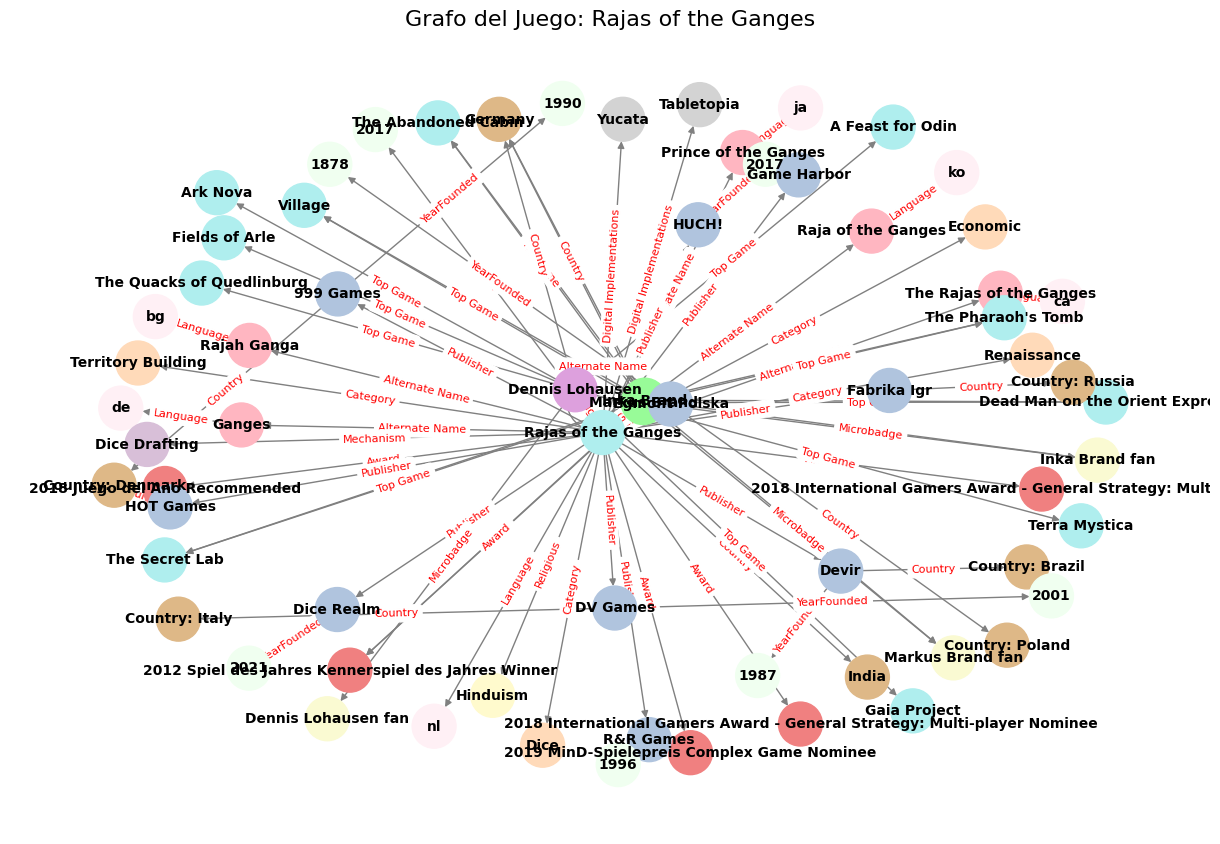

In [40]:
# Crear un grafo dirigido
G = nx.DiGraph()

# Agregar el nodo principal
main_node = game_data["Name"]
G.add_node(main_node, type="Main")

# Agregar nodos relacionados con atributos
# Año
G.add_node(game_data["Year"], type="Year")
G.add_edge(main_node, game_data["Year"], relation="Year")

# Nombres alternativos
for alt_name in game_data["AlternateNames"]:
    name = alt_name["Name"]
    language = alt_name["Language"]
    # Traducción al inglés si no está ya en inglés
    if language != "English":
          translator = GoogleTranslator(source='auto', target='en')
          translated_name = translator.translate(name)
          # translated_name = translator.translate(name, src=language, dest="en")
    else:
        translated_name = name
    # Agregar nodo del nombre traducido
    G.add_node(translated_name, type="AlternateName")
    # Agregar nodo del idioma
    if language not in G:
        G.add_node(language, type="Language")
    # Crear aristas
    G.add_edge(main_node, translated_name, relation="Alternate Name")
    G.add_edge(translated_name, language, relation="Language")

# Categorías
for category in game_data["Categories"]:
    G.add_node(category, type="Category")
    G.add_edge(main_node, category, relation="Category")

# Premios
for award in awards_data:
    G.add_node(award, type="Award")
    G.add_edge(main_node, award, relation="Award")

# Creadores (Designers)
# Agregar nodos relacionados con creadores
for creator in designers_data:
    creator_name = creator['Name']
    G.add_node(creator_name, type='Creator')
    G.add_edge(main_node, creator_name, relation='Creator')

    # Agregar microbadges
    for badge_key in ['Microbadge1', 'Microbadge2']:
        if badge_key in creator:
            badge_name = creator[badge_key]['Name'].replace("Microbadge: ", "")
            G.add_node(badge_name, type='Microbadge')
            G.add_edge(creator_name, badge_name, relation='Microbadge')

    # Agregar premios
    for award in creator['Awards']:
        G.add_node(award, type='Award')
        G.add_edge(creator_name, award, relation='Award')

    # Agregar top games
    for game in creator['TopGames']:
        G.add_node(game, type='TopGame')
        G.add_edge(creator_name, game, relation='Top Game')

    # Agregar país
    creator_country = creator['Country']
    if creator_country not in G:
        G.add_node(creator_country, type='Country')
    G.add_edge(creator_name, creator_country, relation='Country')

# Diseñadores (Artists)
# Agregar nodos relacionados con artistas
for designer in artists_data:
    designer_name = designer['Name']
    G.add_node(designer_name, type='Designer')
    G.add_edge(main_node, designer_name, relation='Designer')

    # Agregar microbadges
    for badge_key in ['Microbadge1', 'Microbadge2']:
        if badge_key in designer:
            badge_name = designer[badge_key]['Name'].replace("Microbadge: ", "")
            G.add_node(badge_name, type='Microbadge')
            G.add_edge(designer_name, badge_name, relation='Microbadge')

    # Agregar premios
    for award in designer['Awards']:
        G.add_node(award, type='Award')
        G.add_edge(designer_name, award, relation='Award')

    # Agregar top games
    for game in designer['TopGames']:
        G.add_node(game, type='TopGame')
        G.add_edge(designer_name, game, relation='Top Game')

    # Agregar país
    designer_country = designer['Country']
    if designer_country not in G:
        G.add_node(designer_country, type='Country')
    G.add_edge(designer_name, designer_country, relation='Country')

# Editores
# Agregar nodos relacionados con publishers
for publisher in publishers_data:
    publisher_name = publisher['Name']
    G.add_node(publisher_name, type='Publisher')
    G.add_edge(main_node, publisher_name, relation='Publisher')

    # Año de fundación
    if 'YearFounded' in publisher and publisher['YearFounded']:
        year_founded = publisher['YearFounded']
        G.add_node(year_founded, type='Year')
        G.add_edge(publisher_name, year_founded, relation="YearFounded")

    # País
    if 'Country' in publisher and publisher['Country']:
        country = publisher['Country']
        country_node = f"Country: {country}"  # Prefijo para evitar conflictos
        if not G.has_node(country_node):
            G.add_node(country_node, type='Country')
        G.add_edge(publisher_name, country_node, relation="Country")

# Temas relacionados
for family in family_data:
    family_theme = family['Theme']
    family_name = family['Name']
    if family_theme != 'Game' and family_theme != 'Admin':
        G.add_node(family_name, type=family_theme)
        G.add_edge(main_node, family_name, relation=family_theme)


# Asignar colores según el tipo de nodo
color_map = {
    "Main": "powderblue",
    "Year": "honeydew",
    "AlternateName": "lightpink",
    "Category": "peachpuff",
    "Award": "lightcoral",
    "Creator": "palegreen",
    "Microbadge": "lightgoldenrodyellow",
    "TopGame": "paleturquoise",
    "Designer": "plum",
    "Publisher": "lightsteelblue",
    "Country": "burlywood",
    "Digital Implementations": "lightgray",
    "Mechanism": "thistle",
    "Religious": "lemonchiffon",
    "Language": "lavenderblush"
}


node_colors = [color_map[G.nodes[node]["type"]] if "type" in G.nodes[node] else "gray" for node in G.nodes]
# Dibujar el grafo
plt.figure(figsize=(12, 8))
# pos = nx.spring_layout(G)
pos = nx.spring_layout(G, k=0.2, iterations=50)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=1000,
    node_color=node_colors,
    font_size=10,
    font_weight="bold",
    edge_color="gray"
)

# Agregar etiquetas para las relaciones
edge_labels = nx.get_edge_attributes(G, "relation")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red", font_size=8)

plt.title("Grafo del Juego: Rajas of the Ganges", fontsize=16)
plt.show()

In [41]:
# Listar todos los nodos del grafo
all_nodes = list(G.nodes)
print("Total de nodos:", len(all_nodes))
print("Nodos únicos:", len(set(all_nodes)))
# Mostrar los nodos
for node in all_nodes:
    print(node)

Total de nodos: 67
Nodos únicos: 67
Rajas of the Ganges
2017
Ganges
de
The Rajas of the Ganges
ca
nl
Rajah Ganga
bg
Prince of the Ganges
ja
Raja of the Ganges
ko
Dice
Economic
Renaissance
Territory Building
2019 MinD-Spielepreis Complex Game Nominee
2018 Juego del Año Recommended
2018 International Gamers Award - General Strategy: Multi-player Winner
2018 International Gamers Award - General Strategy: Multi-player Nominee
Inka Brand
Inka Brand fan
Markus Brand fan
2012 Spiel des Jahres Kennerspiel des Jahres Winner
Village
The Abandoned Cabin
Dead Man on the Orient Express
The Pharaoh's Tomb
The Secret Lab
Germany
Markus Brand
Dennis Lohausen
Dennis Lohausen fan
Ark Nova
Gaia Project
A Feast for Odin
Terra Mystica
The Quacks of Quedlinburg
Fields of Arle
HUCH!
2017
999 Games
1990
Country: Denmark
Devir
1987
Country: Brazil
Dice Realm
2021
DV Games
2001
Country: Italy
Egmont Polska
1878
Country: Poland
Fabrika Igr
Country: Russia
Game Harbor
HOT Games
R&R Games
1996
India
Tabletopia
Yuc

In [42]:
# Listar todos los tripletes del grafo
triplets = [
    (u, v, data["relation"]) for u, v, data in G.edges(data=True) if "relation" in data
]
# Mostrar los tripletes
for triplet in triplets:
    print(triplet)

('Rajas of the Ganges', '2017', 'Year')
('Rajas of the Ganges', 'Ganges', 'Alternate Name')
('Rajas of the Ganges', 'The Rajas of the Ganges', 'Alternate Name')
('Rajas of the Ganges', 'Rajas of the Ganges', 'Alternate Name')
('Rajas of the Ganges', 'nl', 'Language')
('Rajas of the Ganges', 'Rajah Ganga', 'Alternate Name')
('Rajas of the Ganges', 'Prince of the Ganges', 'Alternate Name')
('Rajas of the Ganges', 'Raja of the Ganges', 'Alternate Name')
('Rajas of the Ganges', 'Dice', 'Category')
('Rajas of the Ganges', 'Economic', 'Category')
('Rajas of the Ganges', 'Renaissance', 'Category')
('Rajas of the Ganges', 'Territory Building', 'Category')
('Rajas of the Ganges', '2019 MinD-Spielepreis Complex Game Nominee', 'Award')
('Rajas of the Ganges', '2018 Juego del Año Recommended', 'Award')
('Rajas of the Ganges', '2018 International Gamers Award - General Strategy: Multi-player Winner', 'Award')
('Rajas of the Ganges', '2018 International Gamers Award - General Strategy: Multi-player 

In [43]:
# Contar las conexiones de cada premio para ver si juego y diseñador comparten algún premio
for award in [node for node in G.nodes if G.nodes[node]["type"] == "Award"]:
    connected_nodes = list(G.neighbors(award))
    if len(connected_nodes) > 1:
        print(f"{award} is shared by: {connected_nodes}")

### Base de datos

In [44]:
# Preparar nodos y relaciones
nodes = [{"id": n, "type": G.nodes[n].get("type", "Node")} for n in G.nodes]
edges = [{"source": u, "target": v, "relation": G[u][v].get("relation", "RELATED")} for u, v in G.edges]

# Verifica los datos antes de cargarlos
print("Nodos:", nodes)
print("Relaciones:", edges)


Nodos: [{'id': 'Rajas of the Ganges', 'type': 'TopGame'}, {'id': '2017', 'type': 'Year'}, {'id': 'Ganges', 'type': 'AlternateName'}, {'id': 'de', 'type': 'Language'}, {'id': 'The Rajas of the Ganges', 'type': 'AlternateName'}, {'id': 'ca', 'type': 'Language'}, {'id': 'nl', 'type': 'Language'}, {'id': 'Rajah Ganga', 'type': 'AlternateName'}, {'id': 'bg', 'type': 'Language'}, {'id': 'Prince of the Ganges', 'type': 'AlternateName'}, {'id': 'ja', 'type': 'Language'}, {'id': 'Raja of the Ganges', 'type': 'AlternateName'}, {'id': 'ko', 'type': 'Language'}, {'id': 'Dice', 'type': 'Category'}, {'id': 'Economic', 'type': 'Category'}, {'id': 'Renaissance', 'type': 'Category'}, {'id': 'Territory Building', 'type': 'Category'}, {'id': '2019 MinD-Spielepreis Complex Game Nominee', 'type': 'Award'}, {'id': '2018 Juego del Año Recommended', 'type': 'Award'}, {'id': '2018 International Gamers Award - General Strategy: Multi-player Winner', 'type': 'Award'}, {'id': '2018 International Gamers Award - Ge

#### RDF

Uso de quote:

Convierte caracteres no válidos como espacios y paréntesis en equivalentes codificados. Por ejemplo:

"HOT Games" → "HOT%20Games"

"nostalgia (III)" → "nostalgia%20%28III%29"

In [45]:
# Crear un grafo RDF
rdf_graph = Graph()

# Crear un espacio de nombres para tu grafo
namespace = Namespace("http://flaiba.org/rajasganges/")

# Agregar nodos y relaciones al grafo RDF
for node in nodes:
    node_uri = URIRef(namespace + quote(str(node["id"])))  # Codificar el ID
    rdf_graph.add((node_uri, URIRef(namespace + "type"), Literal(node["type"])))

for edge in edges:
    source_uri = URIRef(namespace + quote(str(edge["source"])))  # Codificar el ID
    target_uri = URIRef(namespace + quote(str(edge["target"])))  # Codificar el ID
    relation_uri = URIRef(namespace + quote(edge["relation"]))  # Codificar la relación
    rdf_graph.add((source_uri, relation_uri, target_uri))

# Serializar el grafo RDF a un archivo
# rdf_graph.serialize(path_context_data + "game_graph.rdf", format="turtle")
# print("Datos RDF exportados a game_grafo.rdf")


##### Queries

In [46]:
for s, p, o in rdf_graph:
    print(f"Sujeto: {s}, Predicado: {p}, Objeto: {o}")


Sujeto: http://flaiba.org/rajasganges/Rajas%20of%20the%20Ganges, Predicado: http://flaiba.org/rajasganges/Category, Objeto: http://flaiba.org/rajasganges/Territory%20Building
Sujeto: http://flaiba.org/rajasganges/Inka%20Brand, Predicado: http://flaiba.org/rajasganges/Microbadge, Objeto: http://flaiba.org/rajasganges/Inka%20Brand%20fan
Sujeto: http://flaiba.org/rajasganges/Rajah%20Ganga, Predicado: http://flaiba.org/rajasganges/type, Objeto: AlternateName
Sujeto: http://flaiba.org/rajasganges/2018%20Juego%20del%20A%C3%B1o%20Recommended, Predicado: http://flaiba.org/rajasganges/type, Objeto: Award
Sujeto: http://flaiba.org/rajasganges/A%20Feast%20for%20Odin, Predicado: http://flaiba.org/rajasganges/type, Objeto: TopGame
Sujeto: http://flaiba.org/rajasganges/Devir, Predicado: http://flaiba.org/rajasganges/type, Objeto: Publisher
Sujeto: http://flaiba.org/rajasganges/Ganges, Predicado: http://flaiba.org/rajasganges/Language, Objeto: http://flaiba.org/rajasganges/de
Sujeto: http://flaiba.or

In [47]:
# Cargar el grafo RDF desde el archivo
rdf_graph = Graph()
rdf_graph.parse(path_context_data + "game_graph.rdf", format="turtle")

# Consulta SPARQL para obtener todos los nodos con su tipo
query = """
PREFIX ns: <http://flaiba.org/rajasganges/>
SELECT ?node ?type
WHERE {
    ?node ns:type ?type .
}
"""

# Ejecutar la consulta
results = rdf_graph.query(query)

# Mostrar resultados
for row in results:
    print(f"Nodo: {row['node']}, Tipo: {row['type']}")


Nodo: http://flaiba.org/rajasganges/1878, Tipo: Year
Nodo: http://flaiba.org/rajasganges/1987, Tipo: Year
Nodo: http://flaiba.org/rajasganges/1990, Tipo: Year
Nodo: http://flaiba.org/rajasganges/1996, Tipo: Year
Nodo: http://flaiba.org/rajasganges/2001, Tipo: Year
Nodo: http://flaiba.org/rajasganges/2021, Tipo: Year
Nodo: http://flaiba.org/rajasganges/2017, Tipo: Year
Nodo: http://flaiba.org/rajasganges/2017%20Meeples%20Choice%20Award%20Nominee, Tipo: Award
Nodo: http://flaiba.org/rajasganges/2018%20International%20Gamers%20Award%20-%20General%20Strategy%3A%20Multi-player%20Nominee, Tipo: Award
Nodo: http://flaiba.org/rajasganges/2018%20International%20Gamers%20Award%20-%20General%20Strategy%3A%20Multi-player%20Winner, Tipo: Award
Nodo: http://flaiba.org/rajasganges/2018%20Juego%20del%20A%C3%B1o%20Recommended, Tipo: Award
Nodo: http://flaiba.org/rajasganges/2019%20MinD-Spielepreis%20Complex%20Game%20Nominee, Tipo: Award
Nodo: http://flaiba.org/rajasganges/2012%20Spiel%20des%20Jahres%20

In [48]:
query = """
PREFIX ns: <http://flaiba.org/rajasganges/>
SELECT ?creator
WHERE {
    <http://flaiba.org/rajasganges/Rajas%20of%20the%20Ganges> ns:Creator ?creator .
}
"""
results = rdf_graph.query(query)

for row in results:
    print(f"Creator: {row['creator']}")

Creator: http://flaiba.org/rajasganges/Inka%20Brand
Creator: http://flaiba.org/rajasganges/Markus%20Brand


In [49]:
query = """
PREFIX ns: <http://flaiba.org/rajasganges/>
SELECT ?relation ?target
WHERE {
    <http://flaiba.org/rajasganges/Rajas%20of%20the%20Ganges> ?relation ?target .
}
"""
results = rdf_graph.query(query)

for row in results:
    print(f"Relación: {row['relation']}, Destino: {row['target']}")


Relación: http://flaiba.org/rajasganges/Alternate%20Name, Destino: http://flaiba.org/rajasganges/Ganges
Relación: http://flaiba.org/rajasganges/Alternate%20Name, Destino: http://flaiba.org/rajasganges/Prince%20of%20the%20Ganges
Relación: http://flaiba.org/rajasganges/Alternate%20Name, Destino: http://flaiba.org/rajasganges/Raja%20of%20the%20Ganges
Relación: http://flaiba.org/rajasganges/Alternate%20Name, Destino: http://flaiba.org/rajasganges/Rajah%20Ganga
Relación: http://flaiba.org/rajasganges/Alternate%20Name, Destino: http://flaiba.org/rajasganges/Rajas%20of%20the%20Ganges
Relación: http://flaiba.org/rajasganges/Alternate%20Name, Destino: http://flaiba.org/rajasganges/The%20Rajas%20of%20the%20Ganges
Relación: http://flaiba.org/rajasganges/Award, Destino: http://flaiba.org/rajasganges/2017%20Meeples%20Choice%20Award%20Nominee
Relación: http://flaiba.org/rajasganges/Award, Destino: http://flaiba.org/rajasganges/2018%20International%20Gamers%20Award%20-%20General%20Strategy%3A%20Multi

## Base de Datos Tabular
* game_tabular.db

### Extracción de estadísticas de las páginas: url_game y url_game_stats

In [56]:
# url_game
def extract_game_info_data(driver: webdriver.Remote, url_game: str) -> pd.DataFrame:
    """
    Extrae datos del juego desde la página principal y devuelve una tabla con las columnas Info_type, Key y Value.

    Parameters:
        driver (webdriver): Instancia de WebDriver.
        url_game (str): URL de la página principal del juego.
    Returns:
        pd.DataFrame: DataFrame con las columnas Info_type, Key y Value.
    """
    rows = []

    # Datos de la página principal
    driver.get(url_game)
    time.sleep(5)
    try:
        game_stats = driver.find_element(By.XPATH, "//ul[@class='gameplay']")
        diff_stats = game_stats.find_elements(By.XPATH, ".//li[@class='gameplay-item']")
        for diff_stat in diff_stats:
            stat_title = diff_stat.find_element(By.XPATH, ".//h3[@class='sr-only']").text.strip()
            if stat_title in ['Number of Players', 'Play Time']:
                min_stat = diff_stat.find_element(By.XPATH, ".//span[@ng-if='min > 0']").text
                max_stat = diff_stat.find_element(By.XPATH, ".//span[@ng-if='max>0 && min != max']").text
                rows.append(["GAME_INFO", stat_title, f"{min_stat} - {max_stat}"])
            elif stat_title == 'Suggested Age':
                stat = diff_stat.find_element(By.XPATH, ".//span[@itemprop='suggestedMinAge']").text
                rows.append(["GAME_INFO", stat_title, stat])

        # Año de lanzamiento
        year_release = driver.find_element(By.XPATH, ".//span[@class='game-year ng-binding ng-scope']").text
        rows.append(["GAME_INFO", "Release Year", year_release.replace('(', '').replace(')', '')])
    except Exception as e:
        print(f"Error al extraer datos de la página principal: {e}")

    # Crear un DataFrame de pandas con las filas recolectadas
    table = pd.DataFrame(rows, columns=["Info_type", "Key", "Value"])
    return table

# Ejemplo de uso:
driver = open_chrome()
game_data_info = extract_game_info_data(driver, url_game)
print(game_data_info)
driver.quit()


   Info_type                Key     Value
0  GAME_INFO  Number of Players    2 - –4
1  GAME_INFO          Play Time  45 - –75
2  GAME_INFO      Suggested Age        12
3  GAME_INFO       Release Year      2017


In [57]:
# url_game_stats
def extract_game_stats_data(driver: webdriver.Remote, url: str) -> pd.DataFrame:
    """
    Extrae datos del juego desde la página de estadísticas y devuelve una tabla en formato DataFrame.
    Args:
        driver (webdriver.Remote): Instancia del controlador de Selenium para interactuar con la página.
        url (str): URL de la página de estadísticas del juego.
    Returns:
        pd.DataFrame: Tabla con los datos extraídos, incluyendo tipo de información, clave y valor.
    """
    driver.get(url)
    rows = []  # Lista para almacenar las filas de la tabla

    try:
        # Esperar que se carguen las secciones principales
        time.sleep(5)

        # Extraer todas las secciones
        sections = driver.find_elements(By.CSS_SELECTOR, "div.panel.panel-condensed")
        for section in sections:
            # Obtener el título de la sección
            section_title = section.find_element(By.CSS_SELECTOR, "h3.panel-title").text.strip()

            # Encontrar los datos dentro de la sección
            items = section.find_elements(By.CSS_SELECTOR, "li.outline-item")
            for item in items:
                try:
                    key = item.find_element(By.CSS_SELECTOR, "div.outline-item-title").text.strip()
                    value = item.find_element(By.CSS_SELECTOR, "div.outline-item-description").text.strip()

                    # Agregar una fila con section_title, key y value
                    rows.append([section_title, key, value])
                except Exception as e:
                    print(f"Error procesando un item en {section_title}: {e}")

    except Exception as e:
        print(f"Error al extraer datos: {e}")

    # Crear un DataFrame de pandas con las filas recolectadas
    table = pd.DataFrame(rows, columns=["Info_type", "Key", "Value"])
    return table


# Extraer datos
driver = open_chrome()
game_data_stats = extract_game_stats_data(driver, url_game_stats)
print(game_data_stats)
driver.quit()

# Guardar los datos en un archivo CSV (opcional)
# game_data_table.to_csv("game_stats.csv", index=False)


           Info_type             Key                            Value
0         GAME STATS     Avg. Rating                            7.731
1         GAME STATS  No. of Ratings                           14,698
2         GAME STATS  Std. Deviation                             1.13
3         GAME STATS          Weight                         2.89 / 5
4         GAME STATS        Comments                            2,124
5         GAME STATS            Fans                              691
6         GAME STATS      Page Views                          899,384
7         GAME RANKS    Overall Rank             156\nHistorical Rank
8         GAME RANKS   Strategy Rank             123\nHistorical Rank
9         PLAY STATS  All Time Plays                           59,431
10        PLAY STATS      This Month                              222
11  COLLECTION STATS             Own                           19,555
12  COLLECTION STATS     Prev. Owned                            2,055
13  COLLECTION STATS

### Formato Pandas

In [58]:
game_tabular_df = pd.concat([game_data_info, game_data_stats], ignore_index=True)
game_tabular_df

,Info_type,Key,Value
0,GAME_INFO,Number of Players,2 - –4
1,GAME_INFO,Play Time,45 - –75
2,GAME_INFO,Suggested Age,12
3,GAME_INFO,Release Year,2017
4,GAME STATS,Avg. Rating,7.731
5,GAME STATS,No. of Ratings,"14,698"
6,GAME STATS,Std. Deviation,1.13
7,GAME STATS,Weight,2.89 / 5
8,GAME STATS,Comments,"2,124"
9,GAME STATS,Fans,691


### Formato CSV

In [59]:
# Exportar a CSV
# game_tabular_df.to_csv(path_context_data + "game_tabular.csv", index=False)
# print("Datos exportados a game_tabular.csv")


### Formato SQLite

In [60]:
sqlite_db_path = path_context_data + "game_tabular.db"

# Guardar en SQLite
# with sqlite3.connect(sqlite_db_path) as conn:
#     game_tabular_df.to_sql("game_data", conn, if_exists="replace", index=False)

# print(f"Datos guardados en {sqlite_db_path} en la tabla 'game_data'.")


In [61]:
# Leer datos desde SQLite
with sqlite3.connect(sqlite_db_path) as conn:
    loaded_df = pd.read_sql("SELECT * FROM game_data", conn)

print(loaded_df)

           Info_type                Key                            Value
0          GAME_INFO  Number of Players                           2 - –4
1          GAME_INFO          Play Time                         45 - –75
2          GAME_INFO      Suggested Age                               12
3          GAME_INFO       Release Year                             2017
4         GAME STATS        Avg. Rating                            7.730
5         GAME STATS     No. of Ratings                           14,688
6         GAME STATS     Std. Deviation                             1.13
7         GAME STATS             Weight                         2.89 / 5
8         GAME STATS           Comments                            2,121
9         GAME STATS               Fans                              690
10        GAME STATS         Page Views                          897,573
11        GAME RANKS       Overall Rank             154\nHistorical Rank
12        GAME RANKS      Strategy Rank            

## Generación de contexto

### Base de Datos vectorila  - Búsqueda híbrida

* Búsqueda por palabras claves + Rank
* Búsqueda Semántica
* Rerank

Hacer Búsqueda Híbrida
Combina palabras clave con embeddings generados por modelos como Sentence-BERT o FAISS para búsquedas semánticas.

Palabras clave: Filtra documentos que contengan las palabras clave extraídas.
Búsqueda Semántica: Usa embeddings para encontrar similitudes.

#### Búsqueda por palabras claves

In [10]:
def preprocess_text(text: str) -> str:
    # Convertir a minúsculas y eliminar puntuación
    text = text.lower()
    # text = re.sub(r'[^\w\s]', '', text)
    # Tokenizar el texto
    tokens = word_tokenize(text)
    # Filtrar las palabras vacías (stopwords)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

In [11]:
preprocess_text("Rajas of the Ganges")

['rajas', 'ganges']

In [12]:
# Obtener los chunks de texto
chunks = collection.get()['documents']
# Limpieza y tokenización
key_words = [preprocess_text(chunk) for chunk in chunks]
# Ranking de palabras clave usando BM25
key_words_bm25 = BM25Okapi(key_words)

# Función de búsqueda
def key_words_search(query: str) -> list:
    query_tokens = preprocess_text(query)
    # print(query_tokens)
    scores = key_words_bm25.get_scores(query_tokens)
    # print(scores)
    results = key_words_bm25.get_top_n(query_tokens, chunks, n=5)
    return results


In [13]:
text = "Vocabulary of the Mughal period has influenced the modern language use."
tokens = key_words_search(text)
print(tokens)  # Salida esperada: ['vocabulary', 'mughal', 'period', 'influenced', 'modern', 'language', 'use']


['Vocabulary of the Mughal period has influenced the modern language use of northern Indian languages. At the same time, the Mughals created permanent new local identities through the standardization of local names (regions, cities, streets). Titles and official names of the Mughal period have often become modern family names.', 'While ownership and taxation were changed according to British ideas, the monetary system did not undergo any significant changes. The company minted silver coins in the name of the Mogulkaiser until 1835. The rough weight of the rupee was taken over by the Mughals and remained unchanged until the abolition of the silver currency in 1945. This shows the sustainable standardizing effect of the Mughal Empire. Thus, the reform of the minting system closely followed the unification of dimensions and weights, some of which are still used in South Asia alongside the official metric units, such as the weight units ser (0.933 kilograms) and tola (11.66 grams). Termino

#### Búsqueda semántica

In [14]:
def semantic_search(query: str) -> list:
  query_vector = model.encode([query])
  results = collection.query(
      query_embeddings=query_vector,
      n_results=5
  )
  return results['documents'][0]

#### Rerank

In [15]:
def search_vectorial(query: str) -> str:
    # Inicialización del modelo de reranking
    reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
    """
    Combina búsquedas semánticas y por palabras clave, luego utiliza un reranker para encontrar el mejor resultado.
    """
    # Resultados de búsqueda semántica
    semantic_results = semantic_search(query)  # Lista de documentos (IDs o textos)

    # Resultados de búsqueda por palabras clave
    key_words_results = key_words_search(query)  # Lista de documentos (IDs o textos)

    # Combinar resultados en pares [query, documento]
    best_results = []
    for result in semantic_results:
        best_results.append([query, result])
    for result in key_words_results:
        best_results.append([query, result])

    # Calcular scores con el modelo de reranking
    scores = reranker.predict(best_results)  # Lista de puntuaciones para cada par [query, documento]
    # print(scores)
    # print(max(scores))
    # Encontrar el mejor resultado
    best_score = max(scores)
    max_index = np.argmax(scores)
    # print(max_index)
    best_result = best_results[max_index][1]

    return best_result


In [16]:
documentos = semantic_search("Where is the Mogul Empire?")
for i, doc in enumerate(documentos):
    print(f"Documento {i + 1}:\n{doc}\n")

Documento 1:
The Mogul Empire, which had natural borders with the Himalayas in the north and the edge mountains of the highlands of Dekkan in the south. In the west and northwest Akbar secured the empire by a balanced foreign policy, which played Persia and the Uzbeks against each other.

Documento 2:
The Mogul Empire was a state that existed on the Indian subcontinent from 1526 to 1858. At the height of its power at the end of the 17th century, the Mogul Empire was located in the northern Indian Indus-Ganges plain around the cities of Delhi, Agra and Lahore. At the height of its power at the end of the 17th century, the Mogul Empire comprised almost the entire subcontinent and parts of today's Afghanistan. On 3.2 million square kilometres lived between 100 and 150 million people. For the year 1700, its share of the world population was estimated at about 29 percent. The Muslim rulers are now called "Mogul-, "Great Mogul-, "Mogul-, "Mogul-, "Mogul-, " and similar names are also found i

In [17]:
documentos = key_words_search("Where is the Mogul Empire?")
for i, doc in enumerate(documentos):
    print(f"Documento {i + 1}:\n{doc}\n")

Documento 1:
Rajas of Tabanan
Śri Magade Nata [son]
Gusti Ngurah Langwang (Prabhu Singasana) [son]
Gusti Ngurah Tabanan (Prabhu Winalwan) [son]
Gusti Wayahan Pamedekan (?-1647) [son]
Gusti Made Pamedekan (1647-c. 1650) [brother]
Gusti Ngurah Tabanan (Prabhu Winalwanan) (second time, c. 1650-?)
Prabhu Nisweng Panida (?-1654?) [son of Gusti Made Pamedekan]
Gusti Made Dalang (1654?-?) [brother]
Gusti Nengah Malkangin [son of Gusti Wayahan Pamedekan]
Gusti Bolo di Malkangin [son of Prabhu Winalwanan]
Gusti Agung Badeng (regent late 17th century) [son-in-law of Gusti Made Pamedekan]
Prabhu Magada Śakti (c. 1700) [son of Prabhu Nisweng Panida]
Anglurah Mur Pamade [son]
Gusti Ngurah Sekar (fl. 1734) [son]
Gusti Ngurah Gede [son]
Gusti Ngurah Made Rai (?-1793) [brother]
Gusti Ngurah Rai Penebel (1793-c. 1820) [brother]
Gusti Ngurah Ubung (c. 1820) [son]
Gusti Ngurah Agung I (c. 1820-1843) [grandson of Gusti Ngurah Made Rai]
Dutch suzerainty 1843-1906
Gusti Ngurah Agung II (1843–1903) [son]

Do

In [18]:
search_vectorial("Where is the Mogul Empire?")

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

'The Mogul Empire was a state that existed on the Indian subcontinent from 1526 to 1858. At the height of its power at the end of the 17th century, the Mogul Empire was located in the northern Indian Indus-Ganges plain around the cities of Delhi, Agra and Lahore. At the height of its power at the end of the 17th century, the Mogul Empire comprised almost the entire subcontinent and parts of today\'s Afghanistan. On 3.2 million square kilometres lived between 100 and 150 million people. For the year 1700, its share of the world population was estimated at about 29 percent. The Muslim rulers are now called "Mogul-, "Great Mogul-, "Mogul-, "Mogul-, "Mogul-, " and similar names are also found in others, especially Western languages. In the state and court language Persian, which replaced the original mother tongue of the Moguls – the Chagata, an East-Turkish language – was the ruler\'s title Padishah.'

### Base de Datos de Grafos - Queries Dinámicas

In [19]:
# Crear un objeto Graph
g = Graph()
# Especificar la ruta al archivo Turtle
game_graph = path_context_data + "game_graph.rdf"
# Cargar el archivo en el objeto Graph, especificando el formato 'turtle'
g.parse(game_graph, format='turtle')
# Ver cuántas tripletas contiene el grafo
print(f"Cantidad de tripletas en el grafo: {len(g)}")


Cantidad de tripletas en el grafo: 149


In [20]:
# for s, p, o in g:
#     print(f"Sujeto: {s}, Predicado: {p}, Objeto: {o}")

In [21]:
def search_graph(prompt: str, model: str) -> str:
    """
    Genera una consulta SPARQL basada en el prompt proporcionado, ejecuta la consulta en un grafo RDF,
    y devuelve los resultados procesados.
    Args:
        prompt (str): Instrucción para generar la consulta SPARQL.
        model (str): Modelo de lenguaje utilizado para generar la consulta.
    Returns:
        str: Resultados procesados de la consulta SPARQL, en formato de texto.
    """

    messages = [
        {
            "role": "system",
            "content": f"You are a query generator in SPARQL and you are responsible for generating a query based on the prompt that the user gives you, the database information is the following:\n{g.serialize(format='turtle')}\nRETURNS ONLY THE QUERY AND NOTHING ELSE"
        },
        {
            "role": "user",
            "content": prompt
        }
    ]

    completion = client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=500
    )
    # print(completion.choices[0].message.content)
    if 'sparql' in completion.choices[0].message.content:
        completion.choices[0].message.content = completion.choices[0].message.content[9:-3].strip()
        # print(completion.choices[0].message.content)
    results = g.query(completion.choices[0].message.content)
    # print(results)
    response = []
    for row in results:
      for key, value in row.asdict().items():  # Convierte el ResultRow a un diccionario
        response.append(str(value).replace("http://flaiba.org/rajasganges/", ""))
    context = ', '.join(response)
    context = context.replace('_', ' ')
    return unquote(context)

In [22]:
# result = search_graph("What is the name of the game?", "Qwen/Qwen2.5-Coder-32B-Instruct")
result = search_graph("Who is the creator of the game?", "Qwen/Qwen2.5-Coder-32B-Instruct")
result

'Inka Brand, Markus Brand'

### Base de Datos Tabular - Queries Dinámicas

In [23]:
conn = sqlite3.connect(path_context_data + 'game_tabular.db')
cursor = conn.cursor()

# Obtener todas las tablas en la base de datos
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

tables_str = ''

# Consultar los campos de cada tabla
for table in tables:
    table_name = table[0]
    tables_str += f"Tabla: {table_name}\n"

    # Obtener información de los campos
    cursor.execute(f"PRAGMA table_info({table_name});")
    columns = cursor.fetchall()

    for column in columns:
        tables_str += f"    Campo: {column[1]}, Tipo: {column[2]}\n"
    tables_str += '\n'

print(tables_str)
# Cerrar la conexión
conn.close()

Tabla: game_data
    Campo: Info_type, Tipo: TEXT
    Campo: Key, Tipo: TEXT
    Campo: Value, Tipo: TEXT




In [24]:
def search_tabular(prompt: str, model: str) -> str:
    """
    Genera una consulta SQL para buscar en la tabla `game_data` basada en el prompt del usuario.
    Args:
        prompt (str): Instrucción del usuario para generar la consulta SQL.
        model (str): Modelo utilizado para generar la consulta SQL.
    Returns:
        str: Resultados obtenidos de la base de datos SQLite después de ejecutar la consulta generada.
    """

    messages = [
        {
            "role": "system",
            "content": """
            You are a SQL query generator. The database contains a single table named `game_data` with the following structure:

                - Info_type: Type of information (e.g., 'GAME_INFO', 'GAME STATS', 'GAME RANKS', 'PLAY STATS', 'COLLECTION STATS', ' PARTS EXCHANGE').
                - Key: The specific attribute (e.g., 'Number of Players', 'Play Time').
                - Value: The value associated with the attribute (e.g., '2-4', '45-75').

            Generate an SQL query based on the user prompt. Ensure that the query matches the structure of the table. In the query the WHERE statement must NOT include Key or Value. RETURN ONLY THE QUERY, NOTHING ELSE.
            """
        },
        {
            "role": "user",
            "content": prompt
        }
    ]

    completion = client.chat.completions.create(
      model=model,
      messages=messages,
      max_tokens=500
    )
    response = completion.choices[0].message.content
    response = completion.choices[0].message.content

    if 'sql' in response:
        response = response[6:-3].strip()
    # print(response)
    # Conectar a la base de datos SQLite
    database_path = path_context_data + "game_tabular.db"
    connection = sqlite3.connect(database_path)
    cursor = connection.cursor()
    try:
        # Ejecutar la consulta SQL
        cursor.execute(response)
        # Obtener los resultados
        context = cursor.fetchall()
        # Verificar si hay resultados
        if not context:
            context = [("No results found.",)]  # Devuelve un mensaje indicando que no hubo resultados
    except sqlite3.Error as e:
        # Manejar errores de SQL
        context = [(f"Error ejecutando la consulta SQL: {e}",)]  # Devuelve el error como resultado
    finally:
        # Cerrar la conexión
        connection.close()
    # Retornar los resultados
    return context


In [25]:
# test = "How many players can play the game rajas of the ganges?"
# test = "What are the statistics of the game?"
test = "What are the statistics of the game and their values?"
context = search_tabular(test, "Qwen/Qwen2.5-72B-Instruct")
print(context)

[('Avg. Rating', '7.730'), ('No. of Ratings', '14,688'), ('Std. Deviation', '1.13'), ('Weight', '2.89 / 5'), ('Comments', '2,121'), ('Fans', '690'), ('Page Views', '897,573')]


## Clasificador

### Basado en un modelo entrenado con ejemplos y embeddings

In [78]:
data = [
    # Base de datos vectorial (label 0)
    {"query": "What is the primary theme of Rajas of the Ganges?", "label": 0},
    {"query": "Who are the designers of Rajas of the Ganges?", "label": 0},
    {"query": "What type of board game is Rajas of the Ganges classified as?", "label": 0},
    {"query": "How is the gameplay of Rajas of the Ganges structured?", "label": 0},
    {"query": "What are the main objectives in Rajas of the Ganges?", "label": 0},
    {"query": "In Rajas of the Ganges, what is the significance of the Ganges river?", "label": 0},
    {"query": "How does Rajas of the Ganges integrate the concept of a worker placement mechanic?", "label": 0},
    {"query": "What are the resources used in Rajas of the Ganges?", "label": 0},
    {"query": "How do players gain points in Rajas of the Ganges?", "label": 0},
    {"query": "What is the role of the Rajah in the game?", "label": 0},
    {"query": "What are the primary actions a player can take on their turn in Rajas of the Ganges?", "label": 0},
    {"query": "How does the game's economy work in Rajas of the Ganges?", "label": 0},
    {"query": "What are the two tracks in Rajas of the Ganges, and how are they linked?", "label": 0},
    {"query": "Can you explain how the dice work in Rajas of the Ganges?", "label": 0},
    {"query": "What is the significance of the temple in Rajas of the Ganges?", "label": 0},
    {"query": "How does Rajas of the Ganges incorporate elements of the Indian subcontinent's culture?", "label": 0},
    {"query": "What role does yoga play in Rajas of the Ganges?", "label": 0},
    {"query": "How does the game’s art reflect Indian culture?", "label": 0},
    {"query": "What is the influence of the Mughal Empire on the design of Rajas of the Ganges?", "label": 0},
    {"query": "How is the game’s player interaction structured?", "label": 0},
    {"query": "What is the role of the peacock in Rajas of the Ganges?", "label": 0},
    {"query": "Can you explain how the peacock throne affects gameplay?", "label": 0},
    {"query": "What is the significance of the Blue Peacock in Indian mythology and how is it represented in the game?", "label": 0},
    {"query": "What is the difference between Rajas of the Ganges and other worker placement games?", "label": 0},
    {"query": "How do players improve their position on the Ganges river?", "label": 0},
    {"query": "What challenges are present when trying to advance on the tracks in Rajas of the Ganges?", "label": 0},
    {"query": "How does the use of the Raja figure impact the game’s strategy?", "label": 0},
    {"query": "What is the connection between the game’s mechanics and the concept of rulers in the Mughal Empire?", "label": 0},
    {"query": "How does the concept of 'karma' relate to Rajas of the Ganges?", "label": 0},
    {"query": "What strategies do you recommend for gaining victory points in Rajas of the Ganges?", "label": 0},
    {"query": "How do players manage resources in Rajas of the Ganges?", "label": 0},
    {"query": "What type of dice are used in Rajas of the Ganges?", "label": 0},
    {"query": "How does the worker placement mechanic affect the decision-making process in Rajas of the Ganges?", "label": 0},
    {"query": "Can you describe the significance of the various buildings in Rajas of the Ganges?", "label": 0},
    {"query": "How do players use the marketplace in the game?", "label": 0},
    {"query": "What are the rewards for completing objectives in Rajas of the Ganges?", "label": 0},
    {"query": "How do players compete for influence over the Rajah in the game?", "label": 0},
    {"query": "What role does diplomacy play in Rajas of the Ganges?", "label": 0},
    {"query": "How does Rajas of the Ganges simulate the management of an Indian principality?", "label": 0},
    {"query": "What historical aspects of the Mughal Empire are reflected in Rajas of the Ganges?", "label": 0},
    {"query": "How is the development of territory represented in Rajas of the Ganges?", "label": 0},
    {"query": "What mechanics in Rajas of the Ganges are inspired by traditional Indian games?", "label": 0},
    {"query": "How does the game portray the societal hierarchy of ancient India?", "label": 0},
    {"query": "How does the concept of the Rajah’s court influence gameplay?", "label": 0},
    {"query": "What are the key differences between the English and German versions of Rajas of the Ganges?", "label": 0},
    {"query": "How did the designers, Inka and Markus Brand, come up with the concept for Rajas of the Ganges?", "label": 0},
    {"query": "How do different cultures, such as the Indian subcontinent and Mughal Empire, influence the game’s design?", "label": 0},
    {"query": "What is the impact of the Indian subcontinent's history on the mechanics of Rajas of the Ganges?", "label": 0},
    {"query": "How do the game's mechanics reflect the idea of spiritual and material progress?", "label": 0},
    {"query": "What is the role of the river in the game’s progression?", "label": 0},
    {"query": "How does Rajas of the Ganges incorporate elements of Indian mythology?", "label": 0},
    {"query": "Can you explain the importance of Man Singh I in the context of the game’s setting?", "label": 0},
    {"query": "How does the game handle the concept of trade and commerce in the Indian subcontinent?", "label": 0},
    {"query": "What are the types of buildings players can construct in Rajas of the Ganges?", "label": 0},
    {"query": "How do the game's designers incorporate the idea of power and wealth into the mechanics?", "label": 0},
    {"query": "How does Rajas of the Ganges balance strategy and luck?", "label": 0},
    {"query": "What does Rajas of the Ganges teach players about the history of the Indian subcontinent?", "label": 0},
    {"query": "How is the concept of peace and conflict represented in the game?", "label": 0},
    {"query": "What kind of player engagement is encouraged in Rajas of the Ganges?", "label": 0},
    {"query": "How do the expansions of Rajas of the Ganges enhance the gameplay?", "label": 0},
    {"query": "What are the historical elements of the Mughal Empire that are depicted in Rajas of the Ganges?", "label": 0},
    {"query": "How is the concept of worker placement explored in Rajas of the Ganges?", "label": 0},
    {"query": "Can you explain how Rajas of the Ganges incorporates a dynamic victory point system?", "label": 0},
    {"query": "What role does the game’s theme of spiritual enlightenment play in its mechanics?", "label": 0},
    {"query": "How does Rajas of the Ganges handle player competition for resources?", "label": 0},
    {"query": "What makes Rajas of the Ganges a unique experience compared to other board games?", "label": 0},
    {"query": "How does the concept of karma and balance manifest in the game?", "label": 0},
    {"query": "What are the risks and rewards of following a more aggressive strategy in Rajas of the Ganges?", "label": 0},
    {"query": "How does the game simulate the rise and fall of a ruler’s influence in ancient India?", "label": 0},
    {"query": "What is the importance of the game’s scoring system?", "label": 0},
    {"query": "How do players use their workers to influence the game?", "label": 0},
    {"query": "What is the role of yoga in the game’s design and mechanics?", "label": 0},
    {"query": "How does Rajas of the Ganges incorporate the significance of the sacred Ganges river?", "label": 0},
    {"query": "What is the gameplay interaction like in a two-player game of Rajas of the Ganges?", "label": 0},
    {"query": "How does Rajas of the Ganges reflect the economic conditions of the Mughal Empire?", "label": 0},
    {"query": "How is the game structured to allow different playstyles?", "label": 0},
    {"query": "What does Rajas of the Ganges teach about the relationship between the ruler and their people?", "label": 0},
    {"query": "What are the challenges players face in building a prosperous state in Rajas of the Ganges?", "label": 0},
    {"query": "How does the role of the Rajah impact the dynamics between players?", "label": 0},
    {"query": "How are historical elements like the peacock throne used to enhance the game’s narrative?", "label": 0},
    {"query": "How does Rajas of the Ganges balance the themes of spiritual growth with material wealth?", "label": 0},
    {"query": "What strategies can players use to advance quickly on the tracks in Rajas of the Ganges?", "label": 0},
    {"query": "How does the influence of the peacock and the throne of India contribute to gameplay?", "label": 0},
    {"query": "What makes Rajas of the Ganges suitable for both casual and experienced gamers?", "label": 0},
    {"query": "How does Rajas of the Ganges reflect the religious diversity of the Indian subcontinent?", "label": 0},
    {"query": "What are the main rewards for building structures in Rajas of the Ganges?", "label": 0},
    {"query": "What is the best way to learn advanced mechanics?", "label": 0},
    {"query": "How do players use dice rolls to influence their strategy in Rajas of the Ganges?", "label": 0},
    {"query": "How does Rajas of the Ganges incorporate the idea of the divine or sacred in its theme?", "label": 0},
    {"query": "What are the major differences between the solo and multiplayer experiences in Rajas of the Ganges?", "label": 0},
    {"query": "How do the different factions or roles affect the player’s approach to strategy in Rajas of the Ganges?", "label": 0},
    {"query": "What mechanics in Rajas of the Ganges are most influenced by the historical context?", "label": 0},
    {"query": "How do the actions of the Rajah affect the players’ abilities to achieve their objectives?", "label": 0},
    {"query": "What are the most common mistakes players make in Rajas of the Ganges?", "label": 0},
    {"query": "What are the advantages and disadvantages of focusing on the Ganges river or the marketplace?", "label": 0},
    {"query": "How do karma and other spiritual elements impact gameplay?", "label": 0},
    {"query": "What should players consider when choosing their role at the start of the game?", "label": 0},
    {"query": "What are the key strategies for mastering Rajas of the Ganges?", "label": 0},
    {"query": "What are the recommended strategies for beginners in Rajas of the Ganges?", "label": 0},
    {"query": "What makes Rajas of the Ganges a strategic and dynamic game?", "label": 0},
    {"query": "How does Rajas of the Ganges challenge players to think about cultural influences?", "label": 0},
    {"query": "How do the various building types contribute to different strategies?", "label": 0},
    {"query": "What tips do you have for players new to worker placement games?", "label": 0},
    {"query": "How can players use the Rajah’s influence to their advantage?", "label": 0},
    {"query": "What are some tips for advancing on both the Ganges river and the fame track?", "label": 0},
    {"query": "How does the game's art influence the player's understanding of the setting?", "label": 0},
    {"query": "What are the key aspects of worker placement mechanics in Rajas of the Ganges?", "label": 0},
    {"query": "What’s the most effective way to balance the game’s two main tracks?", "label": 0},
    {"query": "What should players do if they are falling behind in the game?", "label": 0},
    {"query": "What’s the ideal way to plan ahead in Rajas of the Ganges?", "label": 0},
    {"query": "How do I keep track of my progress on the Ganges river?", "label": 0},
    {"query": "How do the boat mechanics work in Rajas of the Ganges?", "label": 0},
    {"query": "What are some beginner mistakes to avoid in Rajas of the Ganges?", "label": 0},
    {"query": "What is the best way to integrate expansions into Rajas of the Ganges?", "label": 0},
    {"query": "What makes Rajas of the Ganges stand out among other board games?", "label": 0},

    # Base de datos de Grafos (label 1)
    {"query": "Who designed this game?", "label": 1},
    {"query": "What is the name of the game?", "label": 1},
    {"query": "Who is the publisher of this game?", "label": 1},
    {"query": "Which year was this game published?", "label": 1},
    {"query": "What is the top game designed by this author?", "label": 1},
    {"query": "Which category does this game belong to?", "label": 1},
    {"query": "What is the average playtime of this game?", "label": 1},
    {"query": "How many players can play this game?", "label": 1},
    {"query": "Who is the co-designer of this game?", "label": 1},
    {"query": "What is the complexity level of this game?", "label": 1},
    {"query": "What is the recommended age for this game?", "label": 1},
    {"query": "What is the theme of this game?", "label": 1},
    {"query": "Which mechanics does this game use?", "label": 1},
    {"query": "Which awards has this game won?", "label": 1},
    {"query": "Which is the best expansion of this game?", "label": 1},
    {"query": "What is the rank of this game in its category?", "label": 1},
    {"query": "What is the average user rating of this game?", "label": 1},
    {"query": "What is the language of this game?", "label": 1},
    {"query": "What is the main category of this game?", "label": 1},
    {"query": "Where is this board game set?", "label": 1},
    {"query": "What is the relationship between the game designers?", "label": 1},
    {"query": "What religion influences the game?", "label": 1},
    {"query": "When was this game released?", "label": 1},
    {"query": "Are there connections between this game and others by the same author?", "label": 1},
    {"query": "What other games have been published by the same publisher?", "label": 1},
    {"query": "Who are the main collaborators in the game's design?", "label": 1},
    {"query": "What is the connection between this game and other similar-themed games?", "label": 1},
    {"query": "What awards has this artist received for their work?", "label": 1},
    {"query": "Is there a thematic relationship between this designer and others in the same genre?", "label": 1},
    {"query": "What is the main category of this game according to the publisher?", "label": 1},
    {"query": "What cultural elements influence the design of this game?", "label": 1},
    {"query": "What year was the original release and the revised edition?", "label": 1},
    {"query": "What designers have worked on games related to this one?", "label": 1},
    {"query": "What is the publisher's country of origin?", "label": 1},
    {"query": "What is the year of the latest edition of this game?", "label": 1},
    {"query": "What is the minimum playtime for this game?", "label": 1},
    {"query": "What is the maximum playtime for this game?", "label": 1},
    {"query": "Who is the artist of this game?", "label": 1},
    {"query": "Which materials are required to play this game?", "label": 1},
    {"query": "What is the box size of this game?", "label": 1},
    {"query": "Who are the main characters in this game?", "label": 1},
    {"query": "What is the main objective of this game?", "label": 1},
    {"query": "What is the genre of this game?", "label": 1},
    {"query": "What is the release region of this game?", "label": 1},
    {"query": "Which games are similar to this one?", "label": 1},
    {"query": "What is the price of this game?", "label": 1},
    {"query": "Where can I buy this game?", "label": 1},
    {"query": "What is the history of this game's development?", "label": 1},
    {"query": "Who are the key influencers for this game?", "label": 1},
    {"query": "Which magazines have reviewed this game?", "label": 1},
    {"query": "What is the setup time for this game?", "label": 1},
    {"query": "Which game is the sequel to this one?", "label": 1},
    {"query": "What is the publisher's official website?", "label": 1},
    {"query": "Which countries have this game available?", "label": 1},
    {"query": "Which languages is this game available in?", "label": 1},
    {"query": "What is the recommended storage method for this game?", "label": 1},
    {"query": "What is the name of the original designer?", "label": 1},
    {"query": "What are the rules for this game?", "label": 1},
    {"query": "What are the strategies to win this game?", "label": 1},
    {"query": "What is the availability status of this game?", "label": 1},
    {"query": "Who distributes this game?", "label": 1},
    {"query": "Which online platforms sell this game?", "label": 1},
    {"query": "What are the components included in this game?", "label": 1},
    {"query": "Who created the illustrations for this game?", "label": 1},
    {"query": "Who tested this game before release?", "label": 1},
    {"query": "Which events feature this game?", "label": 1},
    {"query": "Who distributes this game in Europe?", "label": 1},
    {"query": "What are the official variants for this game?", "label": 1},
    {"query": "What is the average score of this game?", "label": 1},
    {"query": "What is the recommended storage space for this game?", "label": 1},
    {"query": "Which forums discuss this game?", "label": 1},
    {"query": "Who hosts tournaments for this game?", "label": 1},
    {"query": "What is the weight of the game box?", "label": 1},
    {"query": "Which games inspired this one?", "label": 1},
    {"query": "What is the level of replayability for this game?", "label": 1},
    {"query": "Which tools are necessary to play this game?", "label": 1},
    {"query": "What is the estimated market value of this game?", "label": 1},
    {"query": "Which player skills are tested in this game?", "label": 1},
    {"query": "What are the reviews for this game?", "label": 1},
    {"query": "What are the critical comments about this game?", "label": 1},
    {"query": "Which demographic is this game targeted at?", "label": 1},
    {"query": "What is the balance between luck and skill in this game?", "label": 1},
    {"query": "What is the interaction level among players in this game?", "label": 1},
    {"query": "What is the minimum number of players for this game?", "label": 1},
    {"query": "What is the maximum number of players for this game?", "label": 1},
    {"query": "Who is the official distributor of this game in the US?", "label": 1},
    {"query": "Which accessories are available for this game?", "label": 1},
    {"query": "What role does art play in the game's narrative?", "label": 1},
    {"query": "Who designed Rajas of the Ganges?", "label": 1},
    {"query": "What awards has the game won since its release?", "label": 1},
    {"query": "Who is the artist behind the game's visuals?", "label": 1},
    {"query": "What year was Rajas of the Ganges first published?", "label": 1},
    {"query": "What is the cultural influence in the game?", "label": 1},
    {"query": "Who published the game, and where are they based?", "label": 1},
    {"query": "What is the relationship between the designers of the game?", "label": 1},
    {"query": "Are there connections between this game and others by the same team?", "label": 1},
    {"query": "What is the primary category for this board game?", "label": 1},
    {"query": "Which other games has the artist worked on?", "label": 1},
    {"query": "How is the theme of Hinduism reflected in the gameplay?", "label": 1},
    {"query": "What are the geographic settings depicted in the game?", "label": 1},
    {"query": "What other games have the designers worked on?", "label": 1},
    {"query": "Who collaborated on the expansion design?", "label": 1},
    {"query": "What is the rarity of this game?", "label": 1},
    {"query": "Who owns the copyright for this game?", "label": 1},
    {"query": "What is the best strategy for beginners?", "label": 1},
    {"query": "Who created the cover art for this game?", "label": 1},
    {"query": "What are the main challenges of this game?", "label": 1},
    {"query": "What is the game time flexibility for this game?", "label": 1},
    {"query": "What is the market demand for this game?", "label": 1},
    {"query": "What is the expected shelf life of this game?", "label": 1},
    {"query": "What are the expansion options for this game?", "label": 1},
    {"query": "Who wrote the manual for this game?", "label": 1},
    {"query": "What is the average setup difficulty of this game?", "label": 1},
    {"query": "What is the history behind this game's theme?", "label": 1},
    {"query": "Which regions have this game been popular in?", "label": 1},

    # Base de datos Tabular (label 2)
    {"query": "What is the average rating of this game?", "label": 2},
    {"query": "How many monthly players does this game have?", "label": 2},
    {"query": "How difficult is it to learn this game?", "label": 2},
    {"query": "What is the global ranking of this game?", "label": 2},
    {"query": "How many fans does this game have in total?", "label": 2},
    {"query": "What is the ratio of fans to total players?", "label": 2},
    {"query": "How well-rated is this game among experts?", "label": 2},
    {"query": "How many average players participate per game?", "label": 2},
    {"query": "What is this game's position in the strategy ranking?", "label": 2},
    {"query": "Are there regional differences in the rating?", "label": 2},
    {"query": "How many players does the box recommend for optimal games?", "label": 2},
    {"query": "What is the average playtime according to statistics?", "label": 2},
    {"query": "How difficult is it to master the advanced mechanics?", "label": 2},
    {"query": "What is the number of active monthly players in this game?", "label": 2},
    {"query": "How does this game's rating compare to others in the same genre?", "label": 2},
    {"query": "What data is available about its popularity growth?", "label": 2},
    {"query": "What is the average rating among younger players?", "label": 2},
    {"query": "What statistical changes have occurred in the ranking this year?", "label": 2},
    {"query": "What is the average number of games played per week?", "label": 2},
    {"query": "How many official expansions exist for this game according to metrics?", "label": 2},
    {"query": "What is the average playtime according to user reviews?", "label": 2},
    {"query": "How many players does the box recommend for optimal gameplay?", "label": 2},
    {"query": "What is the difficulty rating of the game?", "label": 2},
    {"query": "What is the global ranking of Rajas of the Ganges?", "label": 2},
    {"query": "How many expansions exist for this game?", "label": 2},
    {"query": "What is the average rating from board game experts?", "label": 2},
    {"query": "How many awards has the game won in total?", "label": 2},
    {"query": "What is the average score required to win?", "label": 2},
    {"query": "What is the number of dice included in the base game?", "label": 2},
    {"query": "What percentage of reviews are highly positive?", "label": 2},
    {"query": "What is the median game length for 4 players?", "label": 2},
    {"query": "How does the game compare in rankings to other economic games?", "label": 2},
    {"query": "What is the estimated number of fans globally?", "label": 2},
    {"query": "How many tiles are included in the base game?", "label": 2},
    {"query": "What is the average cost of the game in different regions?", "label": 2},
    {"query": "How do player counts impact the average playtime?", "label": 2},
    {"query": "What percentage of users recommend the game?", "label": 2},
    {"query": "What are the statistical trends in the game’s popularity?", "label": 2},
    {"query": "How does the game perform in family-friendly rankings?", "label": 2},
    {"query": "What is the average number of players per session?", "label": 2},
    {"query": "What is the recommended age for players?", "label": 2},
    {"query": "How long is the average play session?", "label": 2},
    {"query": "What is the highest player rating this game has received?", "label": 2},
    {"query": "How many fans does this game have currently?", "label": 2},
    {"query": "What is the game's ranking among family board games?", "label": 2},
    {"query": "What is the average playtime per session?", "label": 2},
    {"query": "How many total players have logged games?", "label": 2},
    {"query": "What percentage of players recommend this game?", "label": 2},
    {"query": "How does the game's difficulty compare to similar titles?", "label": 2},
    {"query": "What is the most common rating given by players?", "label": 2},
    {"query": "How has the game's popularity changed over time?", "label": 2},
    {"query": "What is the median number of players per game?", "label": 2},
    {"query": "How many monthly active players does the game have?", "label": 2},
    {"query": "What is the maximum number of players supported?", "label": 2},
    {"query": "How does the average rating vary by region?", "label": 2},
    {"query": "What is the total number of expansions released?", "label": 2},
    {"query": "What is the game's ranking in cooperative board games?", "label": 2},
    {"query": "What percentage of games result in a tie?", "label": 2},
    {"query": "How often do players use house rules?", "label": 2},
    {"query": "What is the average win rate for experienced players?", "label": 2},
    {"query": "What is the most common game length reported?", "label": 2},
    {"query": "How does the game's rating differ between new and veteran players?", "label": 2},
    {"query": "What are the most common player demographics?", "label": 2},
    {"query": "What is the average game length across different group sizes?", "label": 2},
    {"query": "How many tournaments feature this game annually?", "label": 2},
    {"query": "What is the average score per game?", "label": 2},
    {"query": "What is the standard deviation of player ratings?", "label": 2},
    {"query": "How many versions of this game exist globally?", "label": 2},
    {"query": "How has the player base evolved in the last five years?", "label": 2},
    {"query": "What is the game's peak number of concurrent players?", "label": 2},
    {"query": "How many hours does an average player spend on this game?", "label": 2},
    {"query": "What is the gender distribution among players?", "label": 2},
    {"query": "How frequently is this game played in competitions?", "label": 2},
    {"query": "What is the most frequently used strategy among top players?", "label": 2},
    {"query": "What is the minimum recommended number of players?", "label": 2},
    {"query": "How many copies of the game have been sold?", "label": 2},
    {"query": "What is the retention rate for new players?", "label": 2},
    {"query": "What is the average number of games played per day?", "label": 2},
    {"query": "What is the average number of games played per month?", "label": 2},
    {"query": "What is the average rating for the game’s expansions?", "label": 2},
    {"query": "What is the average time per turn?", "label": 2},
    {"query": "What is the typical number of rounds in a game?", "label": 2},
    {"query": "How many players rate this game as their favorite?", "label": 2},
    {"query": "What are the longest recorded playtimes?", "label": 2},
    {"query": "What is the correlation between player experience and scores?", "label": 2},
    {"query": "What is the average rating for strategy games in this category?", "label": 2},
    {"query": "What is the success rate for different strategies?", "label": 2},
    {"query": "How does the game rank in replayability?", "label": 2},
    {"query": "What is the average number of turns per game?", "label": 2},
    {"query": "What is the average number of moves per game?", "label": 2},
    {"query": "How has the game performed in global rankings this year?", "label": 2},
    {"query": "What is the variance in average playtimes?", "label": 2},
    {"query": "How often do players report technical issues?", "label": 2},
    {"query": "What is the average number of games played per week?", "label": 2},
    {"query": "What is the ratio of cooperative to competitive games?", "label": 2},
    {"query": "How does player satisfaction correlate with game length?", "label": 2},
    {"query": "What is the average number of expansions owned per player?", "label": 2},
    {"query": "What is the drop-off rate for first-time players?", "label": 2},
    {"query": "What is the impact of player count on average scores?", "label": 2},
    {"query": "How many awards has the game received overall?", "label": 2},
]


In [79]:
# data = [

#     # Examples for the "vectorial" class (label 0)
#     {"query": "How do you play this game?", "label": 0},
#     {"query": "What is the most effective strategy in this game?", "label": 0},
#     {"query": "Explain the tiebreaker rules in this game.", "label": 0},
#     {"query": "Where can I find a guide for advanced strategies?", "label": 0},
#     {"query": "What does the official rulebook of the game include?", "label": 0},
#     {"query": "How are the final rounds scored?", "label": 0},
#     {"query": "What is the difference between the basic and advanced rules?", "label": 0},
#     {"query": "What resources are essential to win?", "label": 0},
#     {"query": "Explain how the turn order affects the game.", "label": 0},
#     {"query": "Are there rule variants for fewer players?", "label": 0},
#     {"query": "What strategies can I use to improve my performance in the early rounds?", "label": 0},
#     {"query": "Explain the key differences between the versions of the rulebook.", "label": 0},
#     {"query": "How is a tie resolved if it happens in the last round?", "label": 0},
#     {"query": "What tips are there for new players in this game?", "label": 0},
#     {"query": "Where can I find a detailed guide to the roles in the game?", "label": 0},
#     {"query": "How are resources distributed at the beginning of the game?", "label": 0},
#     {"query": "What is the best order to learn the advanced rules?", "label": 0},
#     {"query": "What changes should I make if playing with less time than recommended?", "label": 0},
#     {"query": "What variants exist for playing in solo mode?", "label": 0},
#     {"query": "What does this game expansion include in terms of rules and mechanics?", "label": 0},
#     {"query": "What are the rules for setting up the game?", "label": 0},
#     {"query": "How do you calculate the final score in Rajas of the Ganges?", "label": 0},
#     {"query": "What are the recommended strategies for beginners?", "label": 0},
#     {"query": "What does the official rulebook say about tie-breaking?", "label": 0},
#     {"query": "Where can I find a detailed guide on dice placement strategies?", "label": 0},
#     {"query": "What are the advanced rules for resource management?", "label": 0},
#     {"query": "How do the karma mechanics work in this game?", "label": 0},
#     {"query": "What tips are there for using the marketplace tiles effectively?", "label": 0},
#     {"query": "Are there any quick reference guides for the game?", "label": 0},
#     {"query": "What strategies help in balancing fame and money tracks?", "label": 0},
#     {"query": "What are some common mistakes players make?", "label": 0},
#     {"query": "What is the best way to start building provinces?", "label": 0},
#     {"query": "How do I efficiently manage workers during the mid-game?", "label": 0},
#     {"query": "What are the key actions to prioritize in the early game?", "label": 0},
#     {"query": "Is there a simplified version of the rules for children?", "label": 0},
#     {"query": "What expansions add new mechanics to the game?", "label": 0},
#     {"query": "How do the boats impact gameplay progression?", "label": 0},
#     {"query": "Are there solo mode strategies available?", "label": 0},
#     {"query": "What is the role of the palace tiles in advanced play?", "label": 0},
#     {"query": "What reviews highlight the best strategic aspects of the game?", "label": 0},
#     {"query": "How does scoring work in the advanced mode?", "label": 0},
#     {"query": "What are the main objectives in this game?", "label": 0},
#     {"query": "What are the key mechanics of this game?", "label": 0},
#     {"query": "Where can I find an illustrated guide to the rules?", "label": 0},
#     {"query": "What are the best strategies for resource management?", "label": 0},
#     {"query": "How should I approach the first round in this game?", "label": 0},
#     {"query": "What are the steps to set up the board?", "label": 0},
#     {"query": "Are there any common beginner mistakes to avoid?", "label": 0},
#     {"query": "What are the differences between solo and multiplayer modes?", "label": 0},
#     {"query": "How do I use special abilities effectively?", "label": 0},
#     {"query": "What should I prioritize when upgrading my resources?", "label": 0},
#     {"query": "How do alliances work in cooperative play?", "label": 0},
#     {"query": "Can you explain the scoring system in detail?", "label": 0},
#     {"query": "What is the turn structure in this game?", "label": 0},
#     {"query": "What are the most common winning strategies?", "label": 0},
#     {"query": "Are there any expansions that change the core rules?", "label": 0},
#     {"query": "What are the house rules people often use?", "label": 0},
#     {"query": "How do I balance risk and reward in this game?", "label": 0},
#     {"query": "What are some advanced tactics for experienced players?", "label": 0},
#     {"query": "How does terrain affect gameplay?", "label": 0},
#     {"query": "What are the best practices for managing resources?", "label": 0},
#     {"query": "How do I handle a tie-breaker situation?", "label": 0},
#     {"query": "Are there any official rule clarifications?", "label": 0},
#     {"query": "What is the recommended order to teach the game?", "label": 0},
#     {"query": "How can I adapt the game for younger players?", "label": 0},
#     {"query": "What should I do if we misinterpret a rule mid-game?", "label": 0},
#     {"query": "What scenarios work best for introducing new players?", "label": 0},
#     {"query": "How do I keep the game balanced across different skill levels?", "label": 0},
#     {"query": "What’s the recommended player count for the most fun?", "label": 0},
#     {"query": "Are there any time-saving tips for setup?", "label": 0},
#     {"query": "How do I resolve disputes over rule interpretations?", "label": 0},
#     {"query": "What is the ideal way to plan moves ahead?", "label": 0},
#     {"query": "Can you give an overview of the rulebook?", "label": 0},
#     {"query": "How do bonuses work during scoring?", "label": 0},
#     {"query": "What role does luck play in the overall strategy?", "label": 0},
#     {"query": "How do I calculate resource efficiency?", "label": 0},
#     {"query": "Are there any unwritten strategies that experienced players use?", "label": 0},
#     {"query": "What are the key milestones to focus on in the mid-game?", "label": 0},
#     {"query": "How do endgame conditions trigger?", "label": 0},
#     {"query": "Are there optional rules that add complexity?", "label": 0},
#     {"query": "What is the best way to handle disputes in cooperative mode?", "label": 0},
#     {"query": "How do role cards affect gameplay?", "label": 0},
#     {"query": "What is the best way to learn advanced mechanics?", "label": 0},
#     {"query": "What are some effective ways to slow down opponents?", "label": 0},
#     {"query": "What’s the easiest way to explain this game to new players?", "label": 0},
#     {"query": "How can I make my moves more efficient?", "label": 0},
#     {"query": "What are the common house rules for experienced groups?", "label": 0},
#     {"query": "What kind of strategies work best in a long game?", "label": 0},
#     {"query": "What are some situational strategies I should know?", "label": 0},
#     {"query": "How do environmental factors like lighting affect gameplay?", "label": 0},
#     {"query": "What are the specific scoring bonuses for achievements?", "label": 0},
#     {"query": "What’s the best way to handle aggressive players?", "label": 0},
#     {"query": "How do I speed up the game without losing balance?", "label": 0},
#     {"query": "What’s the most effective way to maximize endgame points?", "label": 0},
#     {"query": "What should I do if I fall behind early in the game?", "label": 0},
#     {"query": "How do I manage high-risk, high-reward strategies?", "label": 0},
#     {"query": "What are the key differences between competitive and cooperative modes?", "label": 0},
#     {"query": "What should I consider when building my strategy for this game?", "label": 0},
#     {"query": "How do I integrate expansions smoothly into gameplay?", "label": 0},
#     {"query": "What are the pros and cons of each faction or role?", "label": 0},

#     # Examples for the "graphs" class (label 1)
#     {"query": "Who designed this game?", "label": 1},
#     {"query": "Who did the artwork for this game?", "label": 1},
#     {"query": "What awards has this designer won?", "label": 1},
#     {"query": "What other games has this artist worked on?", "label": 1},
#     {"query": "What other games have the designers worked on before?", "label": 1},
#     {"query": "Who are the publishers of this game?", "label": 1},
#     {"query": "What is the main category of this game?", "label": 1},
#     {"query": "Where is this board game set?", "label": 1},
#     {"query": "What is the relationship between the game designers?", "label": 1},
#     {"query": "What religion influences the game?", "label": 1},
#     {"query": "When was this game released?", "label": 1},
#     {"query": "Are there connections between this game and others by the same author?", "label": 1},
#     {"query": "What other games have been published by the same publisher?", "label": 1},
#     {"query": "Who are the main collaborators in the game's design?", "label": 1},
#     {"query": "What is the connection between this game and other similar-themed games?", "label": 1},
#     {"query": "What awards has this artist received for their work?", "label": 1},
#     {"query": "Is there a thematic relationship between this designer and others in the same genre?", "label": 1},
#     {"query": "What is the main category of this game according to the publisher?", "label": 1},
#     {"query": "What cultural elements influence the design of this game?", "label": 1},
#     {"query": "What year was the original release and the revised edition?", "label": 1},
#     {"query": "What designers have worked on games related to this one?", "label": 1},
#     {"query": "What role does art play in the game's narrative?", "label": 1},
#     {"query": "Who designed Rajas of the Ganges?", "label": 1},
#     {"query": "What awards has the game won since its release?", "label": 1},
#     {"query": "Who is the artist behind the game's visuals?", "label": 1},
#     {"query": "What year was Rajas of the Ganges first published?", "label": 1},
#     {"query": "What is the cultural influence in the game?", "label": 1},
#     {"query": "Who published the game, and where are they based?", "label": 1},
#     {"query": "What is the relationship between the designers of the game?", "label": 1},
#     {"query": "Are there connections between this game and others by the same team?", "label": 1},
#     {"query": "What is the primary category for this board game?", "label": 1},
#     {"query": "Which other games has the artist worked on?", "label": 1},
#     {"query": "How is the theme of Hinduism reflected in the gameplay?", "label": 1},
#     {"query": "What are the geographic settings depicted in the game?", "label": 1},
#     {"query": "What other games have the designers worked on?", "label": 1},
#     {"query": "Who collaborated on the expansion design?", "label": 1},
#     {"query": "What awards have the designers received individually?", "label": 1},
#     {"query": "How does the game's theme relate to Indian culture?", "label": 1},
#     {"query": "What is the connection between the publisher and other games?", "label": 1},
#     {"query": "Are there sequels or spin-offs related to Rajas of the Ganges?", "label": 1},
#     {"query": "How do the designers’ styles differ from each other?", "label": 1},
#     {"query": "What collaborations exist between this game's team and others?", "label": 1},
#     {"query": "Who are the co-designers of this game?", "label": 1},
#     {"query": "What games has the designer released recently?", "label": 1},
#     {"query": "What is the connection between this designer and others in the same genre?", "label": 1},
#     {"query": "Which publisher is responsible for distributing this game?", "label": 1},
#     {"query": "What collaborations exist between this designer and artist?", "label": 1},
#     {"query": "What cultural influences shaped the game's art?", "label": 1},
#     {"query": "In which region is the game thematically set?", "label": 1},
#     {"query": "What themes does the game's narrative explore?", "label": 1},
#     {"query": "Which awards has this artist won for their work?", "label": 1},
#     {"query": "What other games feature a similar artistic style?", "label": 1},
#     {"query": "What year did the revised edition of this game launch?", "label": 1},
#     {"query": "Who are the primary contributors to the game's mechanics?", "label": 1},
#     {"query": "What is the connection between this publisher and others in the industry?", "label": 1},
#     {"query": "What specific techniques did the artist use in this game?", "label": 1},
#     {"query": "Which games were released alongside this one by the same publisher?", "label": 1},
#     {"query": "What is the religious context of this game's story?", "label": 1},
#     {"query": "Which publisher distributes the game in different regions?", "label": 1},
#     {"query": "What are the main inspirations behind the game's design?", "label": 1},
#     {"query": "What other titles are categorized under the same theme?", "label": 1},
#     {"query": "What role did the lead designer have in other projects?", "label": 1},
#     {"query": "What are the unique traits of the artists involved?", "label": 1},
#     {"query": "Who funded the development of this game?", "label": 1},
#     {"query": "How does this game fit within the designer's portfolio?", "label": 1},
#     {"query": "What are the notable features of the publisher's catalog?", "label": 1},
#     {"query": "Which games share similar mechanics from this designer?", "label": 1},
#     {"query": "Who were the artistic influences behind the game?", "label": 1},
#     {"query": "What relationships exist between this artist and other illustrators?", "label": 1},
#     {"query": "What are the defining characteristics of the category this game belongs to?", "label": 1},
#     {"query": "Which category does the publisher officially classify the game in?", "label": 1},
#     {"query": "What is the historical context represented in the game?", "label": 1},
#     {"query": "What are the notable achievements of the game's developers?", "label": 1},
#     {"query": "How many games has the publisher released in total?", "label": 1},
#     {"query": "Which designer contributed to both this game and similar titles?", "label": 1},
#     {"query": "What historical period does the game's theme represent?", "label": 1},
#     {"query": "What cross-cultural elements are present in the game's narrative?", "label": 1},
#     {"query": "How is the game categorized within its genre?", "label": 1},
#     {"query": "What role does the publisher play in promoting this game?", "label": 1},
#     {"query": "What are the connections between the lead designer and other studios?", "label": 1},
#     {"query": "Which designers worked together on similar games?", "label": 1},
#     {"query": "What is the artist's most acclaimed project?", "label": 1},
#     {"query": "Who oversees the thematic consistency in this publisher's games?", "label": 1},
#     {"query": "How many awards has this game's publisher won?", "label": 1},
#     {"query": "What unique features distinguish this designer's games?", "label": 1},
#     {"query": "What relationships link this publisher to other industry leaders?", "label": 1},
#     {"query": "How does the game's art reflect its cultural themes?", "label": 1},
#     {"query": "What timeline does the publisher follow for releases?", "label": 1},
#     {"query": "What historical figures inspire this game's characters?", "label": 1},
#     {"query": "Which other games have similar thematic elements?", "label": 1},
#     {"query": "What innovations has the designer introduced to the genre?", "label": 1},
#     {"query": "Which publisher editions are available globally?", "label": 1},
#     {"query": "What genre-specific challenges does this game explore?", "label": 1},
#     {"query": "What is the relationship between this artist and the game's theme?", "label": 1},
#     {"query": "What unique marketing approaches has the publisher used?", "label": 1},
#     {"query": "Who are the most prominent artists in this game's style?", "label": 1},
#     {"query": "What are the regional influences on the game's development?", "label": 1},
#     {"query": "What makes this game's category distinct from others?", "label": 1},
#     {"query": "How is the artist's style reflected in the game's components?", "label": 1},
#     {"query": "What partnerships exist between this publisher and others?", "label": 1},
#     {"query": "Who are the supporting designers of this game?", "label": 1},

#     # Examples for the "tabular" class (label 2)
#     {"query": "What is the average rating of this game?", "label": 2},
#     {"query": "How many monthly players does this game have?", "label": 2},
#     {"query": "How difficult is it to learn this game?", "label": 2},
#     {"query": "What is the global ranking of this game?", "label": 2},
#     {"query": "How many fans does this game have in total?", "label": 2},
#     {"query": "What is the ratio of fans to total players?", "label": 2},
#     {"query": "How well-rated is this game among experts?", "label": 2},
#     {"query": "How many average players participate per game?", "label": 2},
#     {"query": "What is this game's position in the strategy ranking?", "label": 2},
#     {"query": "Are there regional differences in the rating?", "label": 2},
#     {"query": "How many players does the box recommend for optimal games?", "label": 2},
#     {"query": "What is the average playtime according to statistics?", "label": 2},
#     {"query": "How difficult is it to master the advanced mechanics?", "label": 2},
#     {"query": "What is the number of active monthly players in this game?", "label": 2},
#     {"query": "How does this game's rating compare to others in the same genre?", "label": 2},
#     {"query": "What data is available about its popularity growth?", "label": 2},
#     {"query": "What is the average rating among younger players?", "label": 2},
#     {"query": "What statistical changes have occurred in the ranking this year?", "label": 2},
#     {"query": "What is the average number of games played per week?", "label": 2},
#     {"query": "How many official expansions exist for this game according to metrics?", "label": 2},
#     {"query": "What is the average playtime according to user reviews?", "label": 2},
#     {"query": "How many players does the box recommend for optimal gameplay?", "label": 2},
#     {"query": "What is the difficulty rating of the game?", "label": 2},
#     {"query": "What is the global ranking of Rajas of the Ganges?", "label": 2},
#     {"query": "How many expansions exist for this game?", "label": 2},
#     {"query": "What is the average rating from board game experts?", "label": 2},
#     {"query": "How many awards has the game won in total?", "label": 2},
#     {"query": "What is the average score required to win?", "label": 2},
#     {"query": "What is the number of dice included in the base game?", "label": 2},
#     {"query": "What percentage of reviews are highly positive?", "label": 2},
#     {"query": "What is the median game length for 4 players?", "label": 2},
#     {"query": "How does the game compare in rankings to other economic games?", "label": 2},
#     {"query": "What is the estimated number of fans globally?", "label": 2},
#     {"query": "How many tiles are included in the base game?", "label": 2},
#     {"query": "What is the average cost of the game in different regions?", "label": 2},
#     {"query": "How do player counts impact the average playtime?", "label": 2},
#     {"query": "What percentage of users recommend the game?", "label": 2},
#     {"query": "What are the statistical trends in the game’s popularity?", "label": 2},
#     {"query": "How does the game perform in family-friendly rankings?", "label": 2},
#     {"query": "What is the average number of players per session?", "label": 2},
#     {"query": "What is the recommended age for players?", "label": 2},
#     {"query": "How long is the average play session?", "label": 2},
#     {"query": "What is the highest player rating this game has received?", "label": 2},
#     {"query": "How many fans does this game have currently?", "label": 2},
#     {"query": "What is the game's ranking among family board games?", "label": 2},
#     {"query": "What is the average playtime per session?", "label": 2},
#     {"query": "How many total players have logged games?", "label": 2},
#     {"query": "What percentage of players recommend this game?", "label": 2},
#     {"query": "How does the game's difficulty compare to similar titles?", "label": 2},
#     {"query": "What is the most common rating given by players?", "label": 2},
#     {"query": "How has the game's popularity changed over time?", "label": 2},
#     {"query": "What is the median number of players per game?", "label": 2},
#     {"query": "How many monthly active players does the game have?", "label": 2},
#     {"query": "What is the maximum number of players supported?", "label": 2},
#     {"query": "How does the average rating vary by region?", "label": 2},
#     {"query": "What is the total number of expansions released?", "label": 2},
#     {"query": "What is the game's ranking in cooperative board games?", "label": 2},
#     {"query": "What percentage of games result in a tie?", "label": 2},
#     {"query": "How often do players use house rules?", "label": 2},
#     {"query": "What is the average win rate for experienced players?", "label": 2},
#     {"query": "What is the most common game length reported?", "label": 2},
#     {"query": "How does the game's rating differ between new and veteran players?", "label": 2},
#     {"query": "What are the most common player demographics?", "label": 2},
#     {"query": "What is the average game length across different group sizes?", "label": 2},
#     {"query": "How many tournaments feature this game annually?", "label": 2},
#     {"query": "What is the average score per game?", "label": 2},
#     {"query": "What is the standard deviation of player ratings?", "label": 2},
#     {"query": "How many versions of this game exist globally?", "label": 2},
#     {"query": "How has the player base evolved in the last five years?", "label": 2},
#     {"query": "What is the game's peak number of concurrent players?", "label": 2},
#     {"query": "How many hours does an average player spend on this game?", "label": 2},
#     {"query": "What is the gender distribution among players?", "label": 2},
#     {"query": "How frequently is this game played in competitions?", "label": 2},
#     {"query": "What is the most frequently used strategy among top players?", "label": 2},
#     {"query": "What is the minimum recommended number of players?", "label": 2},
#     {"query": "How many copies of the game have been sold?", "label": 2},
#     {"query": "What is the retention rate for new players?", "label": 2},
#     {"query": "What is the average rating for the game’s expansions?", "label": 2},
#     {"query": "What is the average time per turn?", "label": 2},
#     {"query": "What is the typical number of rounds in a game?", "label": 2},
#     {"query": "How many players rate this game as their favorite?", "label": 2},
#     {"query": "What are the longest recorded playtimes?", "label": 2},
#     {"query": "What is the correlation between player experience and scores?", "label": 2},
#     {"query": "What is the average rating for strategy games in this category?", "label": 2},
#     {"query": "What is the success rate for different strategies?", "label": 2},
#     {"query": "How does the game rank in replayability?", "label": 2},
#     {"query": "What is the average number of moves per game?", "label": 2},
#     {"query": "How has the game performed in global rankings this year?", "label": 2},
#     {"query": "What is the variance in average playtimes?", "label": 2},
#     {"query": "How often do players report technical issues?", "label": 2},
#     {"query": "What is the ratio of cooperative to competitive games?", "label": 2},
#     {"query": "How does player satisfaction correlate with game length?", "label": 2},
#     {"query": "What is the average number of expansions owned per player?", "label": 2},
#     {"query": "What is the drop-off rate for first-time players?", "label": 2},
#     {"query": "What is the impact of player count on average scores?", "label": 2},
#     {"query": "How many awards has the game received overall?", "label": 2},
# ]

In [80]:
X = [item["query"] for item in data]
y = [item["label"] for item in data]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

x_train_vector = model.encode(x_train)
x_test_vector = model.encode(x_test)

relog = LogisticRegression(max_iter=500, random_state=42)
relog.fit(x_train_vector, y_train)
y_pred_relog = relog.predict(x_test_vector)

In [81]:
report_clf = classification_report(y_test, y_pred_relog, zero_division=1)
matrix = confusion_matrix(y_test, y_pred_relog)

print("Reporte de clasificación Regresión Logística:\n", report_clf)
print("\nMatriz de confusión Regresión Logística:\n", matrix)

Reporte de clasificación Regresión Logística:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94        24
           1       0.83      0.95      0.88        20
           2       1.00      0.91      0.95        22

    accuracy                           0.92        66
   macro avg       0.93      0.93      0.92        66
weighted avg       0.93      0.92      0.93        66


Matriz de confusión Regresión Logística:
 [[22  2  0]
 [ 1 19  0]
 [ 0  2 20]]


In [82]:
def classifier_relog(prompt: str, relog: LogisticRegression) -> str:
    """
    Clasifica un texto ingresado según el modelo entrenado.
    Args:
        prompt (str): El texto a clasificar.
        model: El modelo de codificación de texto (por ejemplo, SentenceTransformer).
        relog: El modelo de regresión logística entrenado
    Returns:
        str: La etiqueta predicha para el texto ingresado.
    """

    # Codificar el texto con el modelo
    prompt_vector = model.encode([prompt])  # El modelo espera una lista de textos
    # Predecir la etiqueta con el modelo de regresión logística
    predicted_label = relog.predict(prompt_vector)[0]
    return predicted_label

In [83]:
# What is the discipline of yoga?
# Where is the Mogul Empire?
# What are the names of the game creators?
query = "What is the discipline of yoga?"
print(classifier_relog(query, relog))

0


In [84]:
query = "how is the influence of the karma in the game?"
print(classifier_relog(query, relog))


0


In [85]:
query = 'What is the maximum recommended age to play the game?'
print(classifier_relog(query, relog))

1


### Basado en LLM

In [86]:
# x_test

In [87]:
client = InferenceClient(api_key=api_key)

def classifier_llm(query: str, model: str) -> str:
      """
      Clasifica una consulta dada en una de las categorías predefinidas:
      'relations', 'statistics', 'reviews', 'rules', 'history', 'geography', 'philosophy', 'religion'.
      Args:
          query (str): La consulta a clasificar.
          model (str): El modelo de lenguaje utilizado para la clasificación.
      Returns:
          str: Un número entero que representa la categoría clasificada:
              - 1 para 'relations' (base de datos de grafos)
              - 2 para 'statistics' (base de datos tabular)
              - 0 para otras categorías (base de datos vectorial)
      """

      messages = [
        {
            "role": "system",
            "content": """
            You are a classifier that predicts classes or categories based on input data, similar to logistic regression.
            """
        },
        {
            "role": "user",
            "content": f"""Classify this query with ONLY ONE of these classes: relations, statistics, reviews, rules, history, geography, philosophy, religion. Return ONLY ONE WORD, the name of the class, nothing else.
            What was the geographical extent of the Great Mogul Empire at its peak? - geography
            What information do you have about the Indian subcontinent? - geography
            Who is the designer of the game Rajas of the Ganges? - relations
            What country is the designer from? - relations
            Who is the publisher of the game? - relations
            What other games did the creator of the game Rajas of the Ganges design? - relations
            Who is the artist behind the game's visuals? - relations
            What is the suggested age to play the game? - statistics
            How many players can play? - statistics
            What is the historical background of the game? - history
            What is a Raja? - history
            What is the philosophy of yoga about? - philosophy
            What is Hinduism? - religion
            How does the game define its rules? - rules
            How to win the game? - rules
            {query} - """
        }
      ]
      completion = client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=500
      )
      response = completion.choices[0].message.content
      predicted_label = 0
      if response == "relations":
          predicted_label = 1  # Base de datos de grafos
      elif response == "statistics":
          predicted_label = 2  # Base de datos tabular
      else:
          predicted_label = 0  # Base de datos vectorial
      return predicted_label


In [88]:
query = "how is the influence of the karma in the game?"
print(classifier_llm(query=query, model="Qwen/Qwen2.5-72B-Instruct"))

0


In [89]:
query = "what is the portuguese in the game?"
print(classifier_llm(query=query, model="Qwen/Qwen2.5-72B-Instruct"))

1


In [90]:
query = 'What was the geographical extent of the Great Mogul Empire?'
print(classifier_llm(query=query, model="Qwen/Qwen2.5-72B-Instruct"))

0


In [91]:
query = 'Who is the designer of the game Rajas of the Ganges?'
print(classifier_llm(query=query, model="Qwen/Qwen2.5-72B-Instruct"))

1


In [92]:
query = 'What is the maximum recommended age to play the game?'
print(classifier_llm(query=query, model="Qwen/Qwen2.5-72B-Instruct"))

2


In [93]:
query = 'What is a Rajá?'
print(classifier_llm(query=query, model="Qwen/Qwen2.5-72B-Instruct"))

0


In [94]:
test_predict = []
for query in x_test:
  test_predict.append(classifier_llm(query=query, model="Qwen/Qwen2.5-72B-Instruct"))
# test_predict

In [95]:
y_pred_llm = []
for prediction, label in zip(test_predict, y_test):
  if prediction == 1:
    y_pred_llm.append(1)
  elif prediction == 2:
    y_pred_llm.append(2)
  else:
    y_pred_llm.append(0)

report_llm = classification_report(y_test, y_pred_llm, zero_division=1)
matrix_llm = confusion_matrix(y_test, y_pred_llm)

print("Reporte de clasificación de la LLM:\n", report_llm)
print("\nMatriz de confusión Regresión Logística:\n", matrix_llm)

Reporte de clasificación de la LLM:
               precision    recall  f1-score   support

           0       0.69      0.75      0.72        24
           1       0.73      0.55      0.63        20
           2       0.84      0.95      0.89        22

    accuracy                           0.76        66
   macro avg       0.76      0.75      0.75        66
weighted avg       0.75      0.76      0.75        66


Matriz de confusión Regresión Logística:
 [[18  4  2]
 [ 7 11  2]
 [ 1  0 21]]


## Chatbot

### Traductores

In [96]:
def translate_prompt(prompt: str) -> tuple[str, str]:
    """
    Detecta el idioma de un texto y lo traduce al inglés si es necesario.
    Args:
        prompt (str): El texto a analizar y traducir.
    Returns:
        tuple[str, str]: Una tupla con el texto traducido y el idioma detectado.
    """

    try:
        # Detectar el idioma del texto
        detected_language = detect(prompt)
        # print(f"Idioma detectado: {detected_language}")
        # Traducir si no está en inglés
        if detected_language != "en":
            translator = GoogleTranslator(source=detected_language, target="en")
            translated_prompt = translator.translate(prompt)
        else:
            translated_prompt = prompt
        return translated_prompt, detected_language
    except Exception as e:
        print(f"Error detectando o traduciendo el idioma: {e}")
        # En caso de error, devolvemos el prompt original y un idioma desconocido
        return prompt, "unknown"


In [97]:
def translate_response(response: str, detected_language: str) -> str:
  """
  Traduce una respuesta al idioma detectado, si no está en inglés.
  Args:
      response (str): El texto a traducir.
      detected_language (str): El idioma objetivo para la traducción.
  Returns:
      str: El texto traducido o el texto original si ya está en inglés.
  """

  # Detectar el idioma del texto
  try:
      # Traducir si no está en inglés
      if detected_language != "en":
          translator = GoogleTranslator(source=detected_language, target=detected_language)
          translated_response = translator.translate(response)
      else:
          translated_response = response
      # Texto traducido
      return translated_response
  except Exception as e:
      print(f"Error detectando o traduciendo el idioma: {e}")
      return response

### Chatbot

In [98]:
def classifier(prompt: str, classifier_type: str ="llm") -> str :
    """
    Clasifica el tipo de consulta y selecciona la base de datos adecuada para la búsqueda.
    Parameters:
        prompt (str): La consulta original del usuario.
        classifier_type (str): El tipo de clasificador a usar ("llm" o "relog"). Por defecto, "llm".
    Returns:
        context: Los resultados de la búsqueda según el tipo de consulta.
    """

    # print(classifier_type)
    # Clasificar el tipo de consulta según el clasificador elegido
    if classifier_type == "llm":
        search_type = classifier_llm(prompt, model="Qwen/Qwen2.5-72B-Instruct")
    elif classifier_type == "relog":
        search_type = classifier_relog(prompt, relog=relog)
    else:
        raise ValueError("Classifier type must be 'llm' or 'relog'.")
    # Realizar la búsqueda en la base de datos correspondiente
    context = None
    if search_type == 1:
        # Base de datos de grafos
        context = search_graph(prompt, "Qwen/Qwen2.5-72B-Instruct")
    elif search_type == 2:
        # Base de datos tabular
        context = search_tabular(prompt, "Qwen/Qwen2.5-72B-Instruct")
    else:
        # Base de datos vectorial
        context = search_vectorial(prompt)
    if not context:
        context = search_vectorial(prompt)

    return context


In [99]:
def chatbot(model: str = "Qwen/Qwen2.5-72B-Instruct", classifier_type: str = "relog") -> str:
  """
  Asistente virtual especializado en el juego de mesa Rajas of the Ganges.
  Args:
      model (str): Modelo de lenguaje utilizado para generar las respuestas.
      classifier_type (str): Tipo de clasificador a usar ("relog" o "llm").
  Returns:
      str: Respuesta traducida al idioma del usuario.
  """

  print("Hello!!! I am your virtual assistant specialized in the board game Rajas of the Ganges.")
  print("You can ask in your language.")
  help_message = "How can I help you? To exit type: "
  input_message = "Enter your question: "
  detected_language = "en"
  while(True):
    help_message = GoogleTranslator(source='auto', target=detected_language).translate(help_message)
    input_message = GoogleTranslator(source='auto', target=detected_language).translate(input_message)
    print(f"\n{help_message} - bye")
    user_prompt = input(input_message)
    if user_prompt.lower() == "bye":
      break

    # Detecta el idioma y traduce a inglés
    translated_prompt, detected_language = translate_prompt(user_prompt)
    # print(f"Idioma: {detected_language} - Traducción del prompt: {translated_prompt})
    context= classifier(translated_prompt, classifier_type)
    messages = [
      {
        "role": "system",
        "content": """
        You are a virtual assistant specialized in the board game Rajas of the Ganges
        """
        },
      {
        "role": "user",
        "content": f""" Answer the question. The response needs to be clear and without extra information. with that context: {context}

        Question: {user_prompt}
        Answer:

        """
      }
    ]
    completion = client.chat.completions.create(
      model=model,
      messages=messages,
      max_tokens=500
    )
    response = completion.choices[0].message.content
    # Traduce la respuesta al idioma del usuario
    translated_response = translate_response(response, detected_language)
    print(translated_response)

## Interacción con el usuario

### Ejemplos de prompts

In [100]:
# Italiano
# In cosa consiste la disciplina dello yoga?
# Dov'è l'Impero Mogul?
# chi è il creatore del gioco?
# chi è il progettista del gioco?
# Quanti giocatori possono giocare?

# Francés
# En quoi consiste la discipline du yoga ?
# Où est l'Empire Moghol ?
# qui est le créateur du jeu ?
# qui est le concepteur du jeu ?
# Combien de joueurs peuvent jouer ?

# Alemán
# Woraus besteht die Disziplin Yoga?
# Wo ist das Mogulreich?
# Wer ist der Spieleentwickler?
# Wer ist der Designer des Spiels?
# Wie viele Spieler können spielen?

# Español
# En qué consiste la disciplina del yoga?
# Dónde queda el Imperio de Mogul?
# quien es el creador de juego?
# quien es el diseñador del juego?
# Cuantos jugadores pueden jugar?

# Inglés
# What is the discipline of yoga?
# Where is the Mogul Empire?
# Who is the game creator?
# Who is the game designer?
# How many players can play?


In [101]:
# chatbot("Qwen/Qwen2.5-72B-Instruct", "relog")
chatbot()

Hello!!! I am your virtual assistant specialized in the board game Rajas of the Ganges.
You can ask in your language.

How can I help you? To exit type: - bye
Enter your question:bye


# Ejercicio 2: Agente

In [29]:
# Descarga de Ollama
!curl -fsSL https://ollama.com/install.sh | sh

# Iniciamos Ollama en background
!rm -f ollama_start.sh
!echo '#!/bin/bash' > ollama_start.sh
!echo 'ollama serve' >> ollama_start.sh
# Make the script executable
!chmod +x ollama_start.sh
!nohup ./ollama_start.sh &

!ollama pull llama3.2 > ollama.log

>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
nohup: appending output to 'nohup.out'
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠧ pulling manifest ⠧ pulling manifest ⠇ pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏ 2.8 MB/2.0 GB                  pull

In [34]:
import logging

# Configuración del logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [35]:
def call_search_wikipedia(query: str, lang: str = 'es') -> str:
    query = f"{query} for the game Rajas of the Ganges"
    try:
        wikipedia.set_lang(lang)
        result = wikipedia.summary(query, sentences=3)
        return result
    except Exception as e:
        return "No information found"

def call_search_graph(query):
  context = search_graph(query, "Qwen/Qwen2.5-72B-Instruct")
  return context

def call_search_tabular(query):
  context = search_tabular(query, "Qwen/Qwen2.5-72B-Instruct")
  return context

def call_search_vectorial(query):
  context = search_vectorial(query)
  return context


In [36]:
tools_list = [
    FunctionTool.from_defaults(fn=call_search_graph, description="Search for information in the graph database. Use: search text"),
    FunctionTool.from_defaults(fn=call_search_tabular, description="Search for information in the tabular database. Use: search text"),
    FunctionTool.from_defaults(fn=call_search_vectorial, description="Search for information in the vectorial/text database. Use: search text"),
    # FunctionTool.from_defaults(fn=call_search_wikipedia, description="Search for information on Wikipedia. Use: search text"),
]

In [37]:
agent_model = Ollama(
    model="llama3.2:latest",
    request_timeout=50.0,
    temperature=0.1,
    context_window=4096
)

# Abre el puerto 8000
Settings.llm = agent_model
!nohup litellm --model ollama/llama3.2:latest --port 8000 > litellm.log 2>&1 &

In [38]:
react_agent = ReActAgent.from_tools(
    tools_list,
    llm=agent_model,
    verbose=True,
    chat_formatter=ReActChatFormatter(),
    system_prompt="""You are a specialized assistant in the board game Rajas of the Ganges. You can respond in spanish or english depending on the query. You need to follow restrictively the next rules:

Thought: Here i explain what i need to do
Action: tool_name
Action Input: "parameter"

## Tools
You have access to a variety of tools. You are responsible for using
the tools in any sequence you deem appropriate to complete the task at hand.
This may require breaking the task into subtasks and using different tools
to complete each subtask.

You have access to the following tools
{call_search_graph}: Action Input: "search text"
{call_search_tabular}: Action Input: "search text"
{call_search_vectorial}: Action Input: "search text"

## Tools themes:
- **Grafos**: GAME ALTERNATIVE NAMES, GAME LANGUAGES, AWARDS, CREATORS, DESIGNERS, PUBLISHERS, OTHER LANGUAGES, COUNTRIES, YEAR.
- **Tabular**: STATISTICS IN GENERAL, RELEASE YEAR, MINIMUM AGE RECOMMENDED, TIME PLAY, AMOUNT OF PLAYERS.
- **Vectorial**: GENERAL RULES, AUTOMATAS RULES, NAVARATNA RULES, GAME OBJECTIVE, COMPETITOR STRATEGY, BEGINNER STRATEGY, SOLO STRATEGY, GAME RELATED HISTORY, GAME RELATED GEOGRAPHY, GAME PHILOSOPHY, GAME RELATED RELIGION.

## Tools Parameters:
- Always use only the query text to call the tools.
- Never use another information to be part of the parameters.
- The tools only accept strings in the parameters.

## Output Format
To answer the question, please use the following format.

```
Thought: I need to use a tool to help me answer the question.
Action: tool name (one of {tool_names}) if using a tool.
Action Input: the input to the tool, in a JSON format representing the kwargs (e.g. {{"input": "hello world", "num_beams": 5}})
```

Please ALWAYS start with a Thought.

Please use a valid string format for the Action Input. Do NOT do this {{'input': 'hello world', 'num_beams': 5}}.

If this format is used, the user will respond in the following format:

```
Observation: tool response
```

You should keep repeating the above format until you have enough information
to answer the question without using any more tools. At that point, you MUST respond
in the one of the following two formats:

```
Thought: I can answer without using any more tools.
Answer: [your answer here]
```

```
Thought: I cannot answer the question with the provided tools.
Answer: Sorry, I cannot answer your query.

## Aditional rules:
- Never modify the literal text of the user's query in the parameter `Action Input`.
- Everytime you receive a new query, forget the previous one. The new query must be treated independently and without previous influences.
- Priorize the tools by the relation theme of the query. Secure yourself by selecting the best tool that adjust to the query with the proportioned themes.
- Never response with information that does not provide directly from the tools.
- The output format must be strict and follow the example proportioned.

## Interaction examples:
Query 1:
- "Where is the Mogul Empire?"
- Thought: I need to search about history and geography.
- Action: call_search_vectorial
- Action Input: "Where is the Mogul Empire?"
- Observation: [Result of the tool]
- Final Answer: The Mogul Empire was located in South Asia.

Query 2:
- "Who is the creator of this game?"
- Thought: I need to search about creators.
- Action: call_search_graph
- Action Input: "Who is the creator of this game?"
- Observation: [Result of the tool]
- Final Answer: The creators of the game are Inka and Markus Brand.

Query 3:
- "How many players can play the game??"
- Thought: I need to search about game rules.
- Action: call_search_tabular
- Action Input: "How many players can play the game??"
- Observation: [Result of the tool]
- Final Answer: 2 to 4 players.


## IMPORTANT:
- Always follow the exact format of the examples for each tool.
- If the query requires information of multiples tools, you MUST use ALL the tolls needed to obtain a FULL answer
- Don't skip any relevant tool although you have part of the answer

## Current Conversation
Below is the current conversation consisting of interleaving human and assistant messages.
""" ,
          react_chat_history=False,
          context="""
          You are a specialized assistant in the board game Rajas of the Ganges. You can respond in spanish or english depending on the query. Remember the outputs of all the tools to use them in the final answer.
          """)


def chat_with_agent(query: str):
    """
    Función para interactuar con el agente ReAct.
    """
    try:
        if not query.strip():
            return "Query is empty"

        response = react_agent.chat(query)
        logger.info(f"Query: {query}")
        logger.info(f"Answer: {response}")
        return response
    except Exception as e:
        return f"Error processing query: {str(e)}"


In [39]:
def execute_example():
    print("=== Example of interaction with the ReAct agent ===")
    queries = [
        # "which are the publishers of the game rajas of the Ganges?",
        # "Where is the Mogul Empire?",
        # "What is the minimum recommended age to play the game?",
        # "How many players can play the game?",
        "Tell me about the Navaratnas Version",
        "How to win the game?,",
        "Show me the game statistics.",
        "What do you know about Hinduism?",
        "Explain to me the end of a round",
        "Who is the creator of the game?"
    ]

    for i, query in enumerate(queries):
        print(f"\nQuery {i+1}: {query}")
        response = chat_with_agent(query)
        print(f"Answer {i+1}: {response}")
        print("------------------------------------------------------")

    print(f"Answer: {response}")

In [40]:
if __name__ == "__main__":
    # Configurar el entorno de ejecución
    import logging
    logging.basicConfig(level=logging.INFO)

    # Ejecutar el ejemplo
    execute_example()

=== Example of interaction with the ReAct agent ===

Query 1: Tell me about the Navaratnas Version
> Running step cbbc8c66-6357-47a4-8d13-9b48c69c532f. Step input: Tell me about the Navaratnas Version
Thought: The current language of the user is: spanish. I need to use a tool to help me answer the question.
Action: call_search_graph
Action Input: {'properties': AttributedDict([('query', AttributedDict([('title', 'Navaratnas Version'), ('text', 'Navaratnas')]))])}
Observation: Error: call_search_graph() got an unexpected keyword argument 'properties'
> Running step e237b8bd-2cf5-4b7a-8893-8bf842a4ea8a. Step input: None
Thought: The tool call_search_graph does not accept the 'properties' keyword argument. I need to use a different tool or format my input differently.
Action: call_search_vectorial
Action Input: {'query': 'Navaratnas Version'}
Observation: Variants and additions Navaratnas variant The Navaratnas variant is recommended as an advanced version of the game. It differs from the

In [119]:
# react_agent = ReActAgent.from_tools(
#     tools_list,
#     llm=agent_model,
#     verbose=True,
#     chat_formatter=ReActChatFormatter(),
#     system_prompt="""You are an assistant that can respond in spanish or english depending on the query. You need to follow restrictively the next rules:

# Thought: Here i explain what i need to do
# Action: tool_name
# Action Input: "parameter"

# ### Availible tools:
# - To call_search_graph: Action Input: "search text"
# - To call_search_tabular: Action Input: "search text"
# - To call_search_wikipedia: Action Input: "search text"
# - To call_search_vectorial: Action Input: "search text"

# ### Database themes:
# - **Grafos**: CREATORS, DESIGNERS, GAME LANGUAGES, PUBLISHERS, OTHER LANGUAGES, AWARDS, COUNTRY, YEAR.
# - **Tabular**: STATISTICS IN GENERAL, RELEASE YEAR, MINIMUM AGE RECOMMENDED, TIME PLAY, AMOUNT OF PLAYERS.
# - **Vectorial**: GENERAL RULES, AUTOMATAS RULES, NAVARATNA RULES, GAME OBJECTIVE, COMPETITOR STRATEGY, BEGINNER STRATEGY, SOLO STRATEGY, HISTORY, GEOGRAPHY, YOGA,

# ### Tools Parameters:
# - Always use only the query text to call the tools.
# - Never use another information to be part of the parameters.
# - The tools only accept strings in the parameters.


# Observation: [Result of the tool]
# ... [Repeat the process if needed]
# Final Answer: The final answer combining all the information

# Instructions for each query:
# 1. Analyze what information you need
# 2. Use the all the available tools one per one with the correct format.
# 3. Combine all the results in one final answer.

# ### Aditional rules:
# - Never modify the user query: Everytime you receive a new query, forget the previous one. The new query must be treated independently and without previous influences.
# - Priorize the tools by the relation theme of the query. Secure yourself by selecting the best tool that adjust to the query with the proportioned themes.
# - Never response with information that does not provide directly from the tools.
# - The output format must be strict and follow the example proportioned.

# ### Interaction examples:
# Query 1:
# - "Where is the Mogul Empire?"
# - Thought: I need to search about history and geography.
# - Action: call_search_vectorial
# - Action Input: "Where is the Mogul Empire?"

# Query 2:
# - "Who is the creator of this game?"
# - Thought: I need to search about creators.
# - Action: call_search_graph
# - Action Input: "Who is the creator of this game?"

# Query 3:
# - "What is the minimum recommended age to play the game?"
# - Thought: I need to search about game rules.
# - Action: call_search_tabular
# - Action Input: "What is the minimum recommended age to play the game?"


# ### IMPORTANT:
# - Always follow the exact format of the examples for each tool.
# - If the query requires information of multiples tools, you MUST use ALL the tolls needed to obtain a FULL answer
# - Don't skip any relevant tool although you have part of the answer
# """
#       ,
#             react_chat_history=False,
#           context="""
#           You are an useful assistant that responds in spanish or english depending on the query. Remember the outputs of all the tools to use them in the final answer.
#           """)


# def chat_con_agente(query: str):
#     """
#     Función para interactuar con el agente ReAct.
#     """
#     try:
#         if not query.strip():
#             return "La consulta está vacía"

#         response = react_agent.chat(query)
#         logger.info(f"Consulta: {query}")
#         logger.info(f"Respuesta: {response}")
#         return response
#     except Exception as e:
#         return f"Error al procesar la consulta: {str(e)}"


## Prueba

In [32]:
# Descarga de Ollama
!curl -fsSL https://ollama.com/install.sh | sh

# Iniciamos Ollama en background
!rm -f ollama_start.sh
!echo '#!/bin/bash' > ollama_start.sh
!echo 'ollama serve' >> ollama_start.sh
# Make the script executable
!chmod +x ollama_start.sh
!nohup ./ollama_start.sh &

!ollama pull llama3.2 > ollama.log

>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
nohup: appending output to 'nohup.out'
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest 
pulling dde5aa3fc5ff... 100% ▕▏ 2.0 GB                         
pulling 966de95ca8a6... 100% ▕▏ 1.4 KB                         
pulling fcc5a6bec9da... 100% ▕▏ 7.7 KB                         
pulling a70ff7e570d9... 100% ▕▏ 6.0 KB                         
pulling 56bb8bd477a5... 100% ▕▏   96 B                         
pulling 34bb5ab01051... 100% ▕▏  561 B                         
verifying sha256 digest 
writing manifes

In [33]:
import logging
# from some_library import FunctionTool, ReActAgent, Ollama, search_graph, search_tabular, search_vectorial

# Configuración del logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Funciones para herramientas con manejo de errores
def call_search_graph(query):
    """Busca información en la base de datos de grafos."""
    try:
        return search_graph(query, "Qwen/Qwen2.5-72B-Instruct")
    except Exception as e:
        logger.error(f"Error in call_search_graph: {e}")
        return "Error retrieving information from graph database."

def call_search_tabular(query):
    """Busca información en la base de datos tabular."""
    try:
        return search_tabular(query, "Qwen/Qwen2.5-72B-Instruct")
    except Exception as e:
        logger.error(f"Error in call_search_tabular: {e}")
        return "Error retrieving information from tabular database."

def call_search_vectorial(query):
    """Busca información en la base de datos vectorial."""
    try:
        return search_vectorial(query)
    except Exception as e:
        logger.error(f"Error in call_search_vectorial: {e}")
        return "Error retrieving information from vectorial database."

# Lista de herramientas
tools_list = [
    FunctionTool.from_defaults(fn=call_search_graph, description="Search for information in the graph database."),
    FunctionTool.from_defaults(fn=call_search_tabular, description="Search for information in the tabular database."),
    FunctionTool.from_defaults(fn=call_search_vectorial, description="Search for information in the vectorial/text database."),
]

# Configuración del modelo LLM
agent_model = Ollama(
    model="llama3.2:latest",
    request_timeout=500.0,
    temperature=0.1,
    context_window=4096
)

# Configuración del agente ReAct
react_agent = ReActAgent.from_tools(
    tools_list,
    llm=agent_model,
    verbose=True,
    chat_formatter=ReActChatFormatter(),
    system_prompt="""
You are a specialized assistant for the board game Rajas of the Ganges. Follow these rules strictly:

## Rules for Interaction
1. Analyze the query and determine the relevant theme (graph, tabular, or vectorial).
2. Use the corresponding tool(s) to answer the query.
3. Combine all results into a comprehensive final answer.

## Tools
- Graph Database: For creators, designers, publishers, etc.
- Tabular Database: For statistics, player count, recommended age, etc.
- Vectorial Database: For rules, strategies, and related history.

## Format
Thought: [What needs to be done]
Action: [Tool Name]
Action Input: [Query]
Observation: [Result from tool]
Final Answer: [Combined result]

Examples:
Query: "Who designed the game?"
Thought: I need to search for the designer.
Action: call_search_graph
Action Input: "Who designed the game?"
Observation: Inka and Markus Brand
Final Answer: The game was designed by Inka and Markus Brand.
""",
    react_chat_history=False,
    context="""
You are a specialized assistant for the board game Rajas of the Ganges. Remember to use tools appropriately and combine results for accurate responses.
""")




In [31]:
# Funciones para interactuar con el agente
def chat_with_agent(query: str):
    """Envía una consulta al agente ReAct y devuelve la respuesta."""
    if not query.strip():
        return "Query is empty."

    try:
        response = react_agent.chat(query)
        logger.info(f"Query: {query}")
        logger.info(f"Answer: {response}")
        return response
    except Exception as e:
        logger.error(f"Error in chat_with_agent: {e}")
        return f"Error processing query: {str(e)}"

def execute_example():
    """Demuestra un ejemplo de interacción con el agente."""
    queries = [
        # "Who are the publishers of Rajas of the Ganges?",
        # "Where is the Mogul Empire?",
        # "What is the minimum recommended age to play the game?",
        # "How many players can play the game?",
        "Tell me about the Navaratnas Version",
        "How to win the game?,",
        "Show me the game statistics.",
        "What do you know about Hinduism?",
        "Explain to me the end of a round",
        "Who is the creator of the game?"
    ]

    for i, query in enumerate(queries):
        print(f"\nQuery {i+1}: {query}")
        response = chat_with_agent(query)
        print(f"Answer {i+1}: {response}")
        print("-" * 50)

if __name__ == "__main__":
    execute_example()


Query 1: Tell me about the Navaratnas Version
> Running step b9d10693-e898-49d8-9742-2ea6ce2668ba. Step input: Tell me about the Navaratnas Version
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: call_search_graph
Action Input: {'title': 'Navaratnas Version', 'text': 'Rajas of the Ganges'}
Observation: Error: call_search_graph() got an unexpected keyword argument 'title'
> Running step f2316ec0-48a0-4ef2-8021-64161ece7e78. Step input: None
Thought: The tool call_search_graph does not support a 'title' keyword argument. I need to use a different tool or adjust my approach.
Action: call_search_tabular
Action Input: {'query': 'Navaratnas Version Rajas of the Ganges'}
Observation: [('No results found.',)]
> Running step 93727a2f-5cda-4080-85f0-8c80d04c374d. Step input: None
Thought: The call_search_tabular tool did not find any relevant information for the query "Navaratnas Version Rajas of the Ganges". I need to try a di

ERROR:__main__:Error in call_search_tabular: 422 Client Error: Unprocessable Entity for url: https://api-inference.huggingface.co/models/Qwen/Qwen2.5-72B-Instruct/v1/chat/completions (Request ID: A0cXLLNCkQ9YJiUSyX_p6)

Failed to deserialize the JSON body into the target type: messages[1].content: data did not match any variant of untagged enum MessageContent at line 1 column 864


Thought: It seems that the graph database tool does not support the "properties" keyword. I need to try a different approach.
Action: call_search_tabular
Action Input: {'query': AttributedDict([('title', 'Navaratnas Version winning conditions')])}
Observation: Error retrieving information from tabular database.
> Running step 514cdb02-0f35-41bd-b0c6-05e66b752e0d. Step input: None
Thought: Since the tabular database tool is not working, I'll try searching in the vectorial/text database.
Action: call_search_vectorial
Action Input: {}
Observation: Error: call_search_vectorial() missing 1 required positional argument: 'query'
> Running step da016a86-6c11-4684-8735-f5e9f427d305. Step input: None
Thought: The vectorial/text database tool requires a query string. I'll try searching for the winning conditions in the Navaratnas Version.
Action: call_search_vectorial
Action Input: {'query': 'Navaratnas Version winning conditions'}
Observation: To fulfill the winning conditions, you need to estab

ERROR:__main__:Error in chat_with_agent: Reached max iterations.


Observation: Error: Could not parse output. Please follow the thought-action-input format. Try again.
Answer 3: Error processing query: Reached max iterations.
--------------------------------------------------

Query 4: What do you know about Hinduism?
> Running step 9ba51a06-6655-4dbd-915d-d08a34d3a918. Step input: What do you know about Hinduism?
Thought: The current language of the user is not specified. I need to use a tool to help me answer the question.
Action: call_search_vectorial
Action Input: {'query': AttributedDict([('title', 'Hinduism'), ('text', 'Hinduism')])}


ERROR:__main__:Error in call_search_vectorial: 'AttributedDict' object has no attribute 'lower'


Observation: Error retrieving information from vectorial database.
> Running step a502e2be-10b0-4ade-a864-d6d582888aac. Step input: None
Thought: I need to use a different tool to retrieve information about Hinduism.
Action: call_search_graph
Action Input: {}
Observation: Error: call_search_graph() missing 1 required positional argument: 'query'
> Running step a0a604f4-bd86-420d-8e22-855b4db4608f. Step input: None
Thought: The call_search_graph function requires a query string. I need to provide more context or information about Hinduism to retrieve accurate results.
Action: call_search_tabular
Action Input: {'query': 'Hinduism'}
Observation: [('No results found.',)]
> Running step f3c93441-b768-47b6-9787-a9343880bcf7. Step input: None
Thought: No relevant information was found in the tabular database. I'll try searching again with a different approach.
Action: call_search_vectorial
Action Input: {'query': 'Hindu mythology', 'text': 'Hindu gods'}
Observation: Error: call_search_vectori

ERROR:__main__:Error in chat_with_agent: Reached max iterations.


Thought: The call_search_vectorial function does not accept the 'text' keyword argument. I need to use a different tool or approach to retrieve information about Hinduism.
Action: call_search_graph
Action Input: {'query': 'Hindu mythology', 'properties': AttributedDict([('title', 'Hindu Mythology')])}
Observation: Error: call_search_graph() got an unexpected keyword argument 'properties'
Answer 4: Error processing query: Reached max iterations.
--------------------------------------------------

Query 5: Explain to me the end of a round
> Running step 8889b39d-e97c-4341-8051-c32626b542fa. Step input: Explain to me the end of a round
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: call_search_vectorial
Action Input: {'properties': AttributedDict([('query', AttributedDict([('title', 'Navaratnas Version End of Round')]))])}
Observation: Error: call_search_vectorial() got an unexpected keyword argument 'properties'
> Runni

In [ ]:
# if __name__ == "__main__":
#     # Configurar el entorno de ejecución
#     import logging
#     logging.basicConfig(level=logging.INFO)

#     # Ejecutar el ejemplo
#     execute_example()